In [1]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import seaborn as sns
import networkx as nx
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test, logrank_test, pairwise_logrank_test
from scipy.stats import chi2_contingency
from scipy.stats import spearmanr
from utils import PROJECT_ROOT
from utils import reverse_dict, preprocess_Danenberg, preprocess_Jackson
from definitions import (
    get_node_id,
    get_node_color,
    Protein_list_Danenberg,
    Protein_list_Jackson,
    Protein_list_display_Danenberg,
    Protein_list_display_Jackson,
    Cell_types_displayed_Danenberg,
    Cell_types_displayed_Jackson,
    color_palette_Bigraph,
    color_palette_clinical,
    get_paired_markers
)
sys.path.append("./..")
from cell_graph import Cell_Graph
from bi_graph import BiGraph
from population_graph import Population_Graph
from explainer import Explainer

# 0. Data Exploration and preprocessing

## Danenberg et al

In [2]:
SC_d_raw = pd.read_csv('Datasets/Danenberg_et_al/cells.csv') 
survival_d_raw = pd.read_csv('Datasets/Danenberg_et_al/clinical.csv')
SC_d, SC_iv, survival_d, survival_iv = preprocess_Danenberg(SC_d_raw, survival_d_raw)

Initially,
718 patients (794 images) with cell data, 2604 patients with clinical data, 

Remove images without invasive tumor,
693 patients (749 images) with cell data, 2604 patients with clinical data, 

Remove patients with no clinical data,
683 patients (737 images) with cell data and clinical data, 

Remove images with less than 500 cells
579 patients (621 images) with more than 500 cells and clinical data, 

After splitting into discovery and validation sets,
379 patients and 404 images in the discovery set
200 patients and 217 images in the validation set


/cis/home/zwang/Projects/BiGraph4TME/Demo/utils.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survival_dc["status"] = survival_dc["status"].map({"0:LIVING": 0, "1:DECEASED": 1})
/cis/home/zwang/Projects/BiGraph4TME/Demo/utils.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survival_iv["status"] = survival_iv["status"].map({"0:LIVING": 0, "1:DECEASED": 1})


## Jackson et el

In [55]:
SC_ev_raw = pd.read_csv('Datasets/Jackson_et_al/cells.csv') 
survival_ev_raw = pd.read_csv('Datasets/Jackson_et_al/clinical.csv')
SC_ev, survival_ev = preprocess_Jackson(SC_ev_raw, survival_ev_raw)

Initially,
285 patients, 376 images, and 855668 cells

Remove normal breast samples
281 patients, 289 images, and 855668 cells

Remove images with less than 500 cells
266 patients, 270 images, and 762616 cells


# 1. Fit BiGraph model with discovery set

In [52]:
bigraph_ = BiGraph(k_patient_clustering = 20)
population_graph_discovery, patient_subgroups_discovery = bigraph_.fit_transform(
    SC_d, 
    survival_data = survival_d
)

There is a soft wl subtree kernel fitted before. We will load it directly.
If you want to re-fit soft wl subtree kernel, please delete the file 'fitted_soft_wl_subtree.pkl'
It takes a while to load the fitted soft wl subtree kernel.
An overview of the input cellular graphs is as follows: 
	 379 unique patients.
	 32 unique cell types.
	 670335 total cells, 1768.69 cells per patient.
An overview of the identified patterns is as follows: 
	 66 discovered patterns.
Start generating population graph.
Initialized Population_Graph, k_clustering =  20 , k_estimate =  3 , resolution =  1.0 , size_smallest_cluster =  10 , seed =  1
Population graph generated.
Start detecting patient subgroups.
Patient subgroups detected.
There are 7 patient subgroups, 0 ungrouped patients
Start finding characteristic patterns for each patient subgroup.
Characteristic patterns found.
Since survival data is provided, we will sort patient subgroups by survival.\But keep in mind, survival data is not touched in TME

# 2. Validate BiGraph model with validation sets

## Inner-validation

In [53]:
population_graph_iv, patient_subgroups_iv, histograms_iv = bigraph_.transform(
    SC_iv,
    survival_data = survival_iv
)

Basic data preprocessing done. An overview of the data is as follows: 
	 200 unique patients.
	 32 unique cell types.
	 345828 total cells, 1729.14 cells per patient.


Estimating TME patterns from 200 graphs, median number of nodes is 1455.5, node feature dimension is 32
Initialized Population_Graph, k_clustering =  20 , k_estimate =  3 , resolution =  1.0 , size_smallest_cluster =  10 , seed =  1
Since survival data is provided, we will analyze survival of each mapped subgroup. \But keep in mind, survival data is not touched in subgroup mapping.
Survival analysis done.


## External validation

### Cell phenotyping system mapping

In [56]:
from sklearn.neighbors import NearestNeighbors
def map_cell_types(SC_d, SC_ev, paired_proteins):
    cell_types_d = SC_d["celltypeID"].values
    protein_expression_d = SC_d[[i[0] for i in paired_proteins]].values
    # normalize protein expression
    protein_expression_d = (
        protein_expression_d - np.mean(protein_expression_d, axis=0)
    ) / np.std(protein_expression_d, axis=0)
    protein_expression_ev = SC_ev[[i[1] for i in paired_proteins]].values
    # normalize protein expression
    protein_expression_ev = (
        protein_expression_ev - np.mean(protein_expression_ev, axis=0)
    ) / np.std(protein_expression_ev, axis=0)
    centroids = np.zeros((len(np.unique(cell_types_d)), len(paired_proteins)))
    for i in range(len(np.unique(cell_types_d))):
        centroids[i] = np.mean(protein_expression_d[cell_types_d == i], axis=0)
    cell_types_ev_hat = np.zeros(len(protein_expression_ev), dtype=int)
    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(centroids)
    # to avoid memory error, we split the data into chunks
    n_chunks = 100
    chunk_size = len(protein_expression_ev) // n_chunks
    for i in range(n_chunks):
        start = i * chunk_size
        end = (i + 1) * chunk_size
        _, indices = neigh.kneighbors(protein_expression_ev[start:end])
        cell_types_ev_hat[start:end] = indices.flatten()
    # the last chunk
    _, indices = neigh.kneighbors(protein_expression_ev[end:])
    cell_types_ev_hat[end:] = indices.flatten()
    SC_ev["celltypeID_original"] = SC_ev["celltypeID"]
    SC_ev["celltypeID"] = list(cell_types_ev_hat)
    return SC_ev


SC_ev = map_cell_types(
    SC_d, SC_ev, get_paired_markers(source="Danenberg", target="Jackson")
)
population_graph_ev, patient_subgroups_ev, histograms_ev = bigraph_.transform(
    SC_ev, survival_data=survival_ev
)

Basic data preprocessing done. An overview of the data is as follows: 
	 266 unique patients.
	 32 unique cell types.
	 762616 total cells, 2866.9774436090224 cells per patient.
Estimating TME patterns from 266 graphs, median number of nodes is 2732.0, node feature dimension is 32
Initialized Population_Graph, k_clustering =  20 , k_estimate =  3 , resolution =  1.0 , size_smallest_cluster =  10 , seed =  1
Since survival data is provided, we will analyze survival of each mapped subgroup. \But keep in mind, survival data is not touched in subgroup mapping.
Survival analysis done.


# 3. Reproduce results and figures

## Fig.3 Overview of datasets

### Fig.3.a. Data partition for Danenberg et al

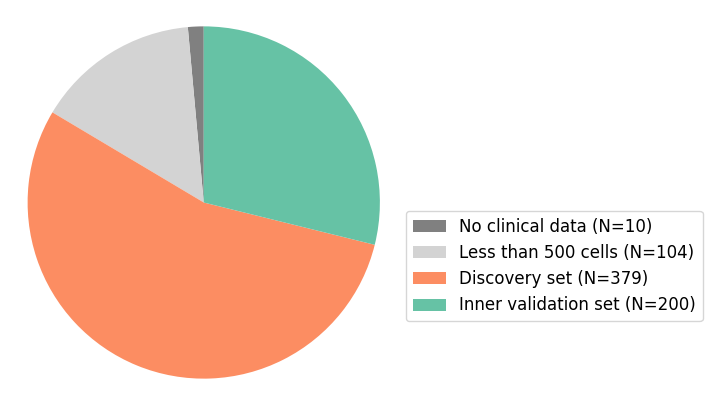

In [6]:
f, ax = plt.subplots(figsize=(5,5), subplot_kw=dict(aspect="equal"))
labels = ['No clinical data (N=10)', 'Less than 500 cells (N=104)', 'Discovery set (N=379)', "Inner validation set (N=200)"]
sizes = [10, 104, 379, 200]
colors = ['grey','lightgrey',sns.color_palette("Set2")[1],sns.color_palette("Set2")[0]]
pie = ax.pie(sizes, labels=None,  startangle=90, colors=colors,wedgeprops=dict( linewidth=1))
ax.legend(labels, loc="upper left", bbox_to_anchor=(1, 0.5), fontsize = 12, )
# Equal aspect ratio ensures that the pie chart is circular.
plt.axis('equal')
# Show the plot
plt.show()

### Fig.3.b Data partition for Jackson et al

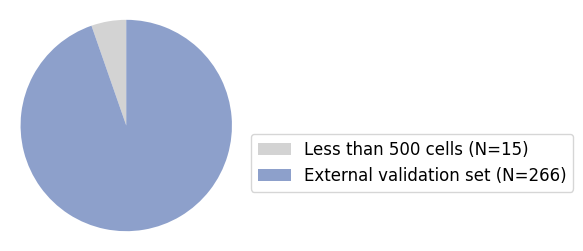

In [7]:
f, ax = plt.subplots(figsize=(3,3), subplot_kw=dict(aspect="equal"))
labels = ['Less than 500 cells (N=15)',  "External validation set (N=266)"]
sizes = [15, 266]
colors = ['lightgrey',sns.color_palette("Set2")[2]]
pie = ax.pie(sizes, labels=None,  startangle=90, colors=colors,wedgeprops=dict( linewidth=1))
ax.legend(labels, loc="upper left", bbox_to_anchor=(1, 0.5), fontsize = 12, )

# Equal aspect ratio ensures that the pie chart is circular.
plt.axis('equal')
# Show the plot
plt.show()

## Fig.4 Signature map and abundance

### Load Signature map and their distribution (Proportions)

In [29]:
Signatures = bigraph_.fitted_soft_wl_subtree.Signatures
Histograms = bigraph_.fitted_soft_wl_subtree.Histograms
Proportions = Histograms/np.sum(Histograms, axis=1, keepdims=True)
# Proportion of each pattern presented in each patient's cellular graphs
DF_proportion = pd.DataFrame(Proportions)
DF_proportion = DF_proportion.melt(
    var_name="pattern_id", value_name="proportion"

)
DF_proportion['pattern_id'] = DF_proportion['pattern_id'].astype(str)

### Reordered tme patterns by tumor niches, immune niches, stromal niches, and interfacing niches (Only for visualization purpose)

In [30]:
# Define tumor niches, immune niches, stromal niches, and interfacing niches
threshold = 0.5  # does not impact the downstream analysis, only imapct the presentation of the signature map
tumor_niche = np.where(
    (np.sum(Signatures[:, :16] > threshold, axis=1) > 0)
    & (np.sum(Signatures[:, 16:] > threshold, axis=1) == 0)
)[0]
immune_niche = np.where(
    (np.sum(Signatures[:, :16] > threshold, axis=1) == 0)
    & (np.sum(Signatures[:, 16:27] > threshold, axis=1) > 0)
    & (np.sum(Signatures[:, 27:] > threshold, axis=1) == 0)
)[0]
stromal_niche = np.where(
    (np.sum(Signatures[:, :16] > threshold, axis=1) == 0)
    & (np.sum(Signatures[:, 16:27] > threshold, axis=1) == 0)
    & (np.sum(Signatures[:, 27:] > threshold, axis=1) > 0)
)[0]
interacting_niche = [
    i
    for i in range(Signatures.shape[0])
    if i not in np.concatenate([tumor_niche, immune_niche, stromal_niche])
]
print("There are {} identified TME patterns.".format(Signatures.shape[0]))
print(
    "There are {} tumor niches, {} immune niches, {} stromal niches, and {} interacting niches.".format(
        len(tumor_niche), len(immune_niche), len(stromal_niche), len(interacting_niche)
    )
)
tme_pattern_orders = np.concatenate([tumor_niche, immune_niche, stromal_niche, interacting_niche])

There are 66 identified TME patterns.
There are 37 tumor niches, 4 immune niches, 11 stromal niches, and 14 interacting niches.


### Plot signature map

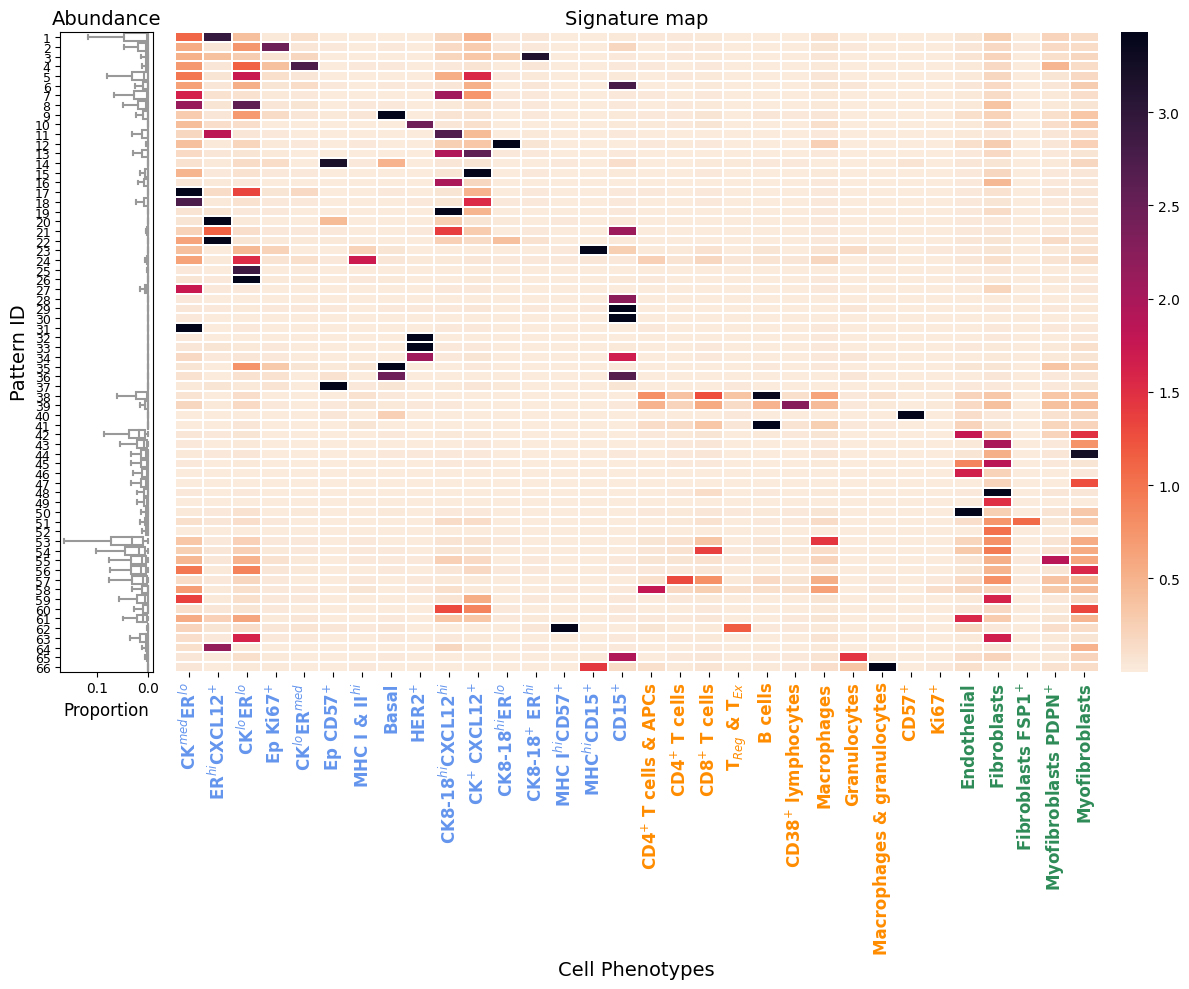

In [31]:
f, ax = plt.subplots(
    1,
    3,
    figsize=(12, 10),
    tight_layout=True,
    gridspec_kw={"width_ratios": [1, 10, 0.3]},
)

sns.heatmap(
    Signatures[tme_pattern_orders, :],
    ax=ax[1],
    cmap="rocket_r",
    linewidth=0.005,
    cbar=True,
    cbar_ax=ax[2],
    edgecolor="black",
    vmax=np.percentile(Signatures, 99),
    vmin=np.percentile(Signatures, 5),
)

ax[1].get_yaxis().set_visible(False)
ax[1].set_title("Signature map", fontsize=14)
ax[1].set_xticklabels(
    Cell_types_displayed_Danenberg, rotation=90, fontsize=12, fontweight="bold"
)
ax[1].set_xlabel("Cell Phenotypes", fontsize=14)
xtickcolors = ["cornflowerblue"] * 16 + ["darkorange"] * 11 + ["seagreen"] * 5
for xtick, color in zip(ax[1].get_xticklabels(), xtickcolors):
    xtick.set_color(color)
ax[2].get_xaxis().set_visible(False)

sns.boxplot(
    y="pattern_id",
    x="proportion",
    data=DF_proportion,
    showfliers=False,
    ax=ax[0],
    color="white",
    order=[str(i) for i in tme_pattern_orders],
    fliersize=0.5,
)
ax[0].set_xlabel("Proportion", fontsize=12)
ax[0].set_title("Abundance", fontsize=14)
ax[0].set_yticklabels([i + 1 for i in range(len(tme_pattern_orders))], fontsize=9)
ax[0].set_ylabel("Pattern ID", fontsize=14)
ax[0].invert_xaxis()
plt.show()

## Fig.5 Demonstrate Inter-patient Similarities

In [22]:
Similarity_matrix = bigraph_.fitted_soft_wl_subtree.Similarity_matrix
Cellular_graphs = bigraph_.fitted_soft_wl_subtree.X
patient_ids_d = [cellular_graph[0] for cellular_graph in Cellular_graphs]
print("The shape of the similarity matrix is", Similarity_matrix.shape)
print("There are {} patients".format(len(patient_ids_d)))

The shape of the similarity matrix is (379, 379)
There are 379 patients


In [23]:
def get_pos(G):
    x = nx.get_node_attributes(G, "coorX")
    y = nx.get_node_attributes(G, "coorY")
    pos = {}
    for key, _ in x.items():
        pos[key] = (x[key], y[key])
    return pos

### Fig.5.a Template patient

The number of cells in the template patient is 2118


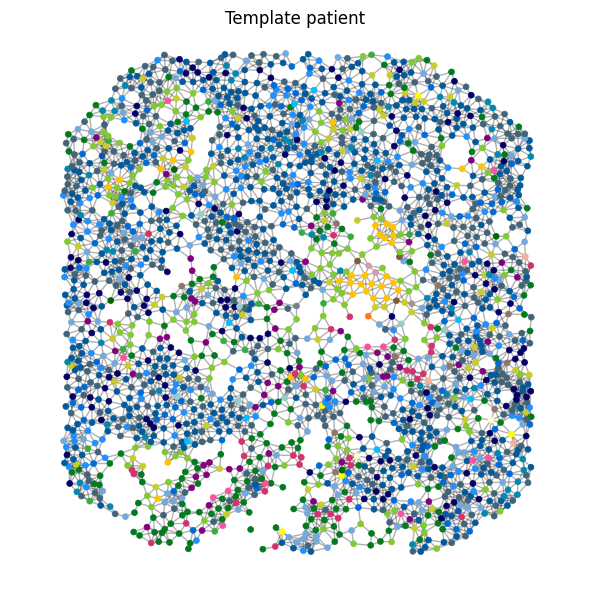

In [24]:
template_patient_id = 'MB-0882'
template_image_id = 50
adj = Cellular_graphs[patient_ids_d.index(template_patient_id)][1] # The adjacency matrix of the template patient
cells_template = SC_d[SC_d['imageID'] == template_image_id].reset_index(drop=True)
assert len(cells_template) == adj.shape[0]
print("The number of cells in the template patient is", len(cells_template))
# For visualization propose, we set the diagonal of the adjacency matrix to be 0
np.fill_diagonal(adj, 0) # Remove self loops
# For visualization purpose, we only show edges with a weight higher than 0.01
adj[adj < 0.01] = 0
G = nx.from_numpy_array(adj)
nx.set_node_attributes(G, cells_template["coorX"], "coorX")
nx.set_node_attributes(G, cells_template["coorY"], "coorY")
nx.set_node_attributes(G, cells_template["meta_description"], "meta_description")
f, ax = plt.subplots(
    1,
    1,
    figsize=(6, 6),
    tight_layout=True,
)
cell_color_dict = get_node_color("Danenberg", "CellType")
nx.draw_networkx_nodes(
    G,
    get_pos(G),
    node_size=18,
    node_color=[
        cell_color_dict[cell_type]
        for cell_type in list(nx.get_node_attributes(G, "meta_description").values())
    ],
    # edgecolors="black",
    linewidths=0.5,
    ax=ax,
)
nx.draw_networkx_edges(G, get_pos(G), ax=ax, alpha=0.3, width=1)
ax.set(
    title = "Template patient",
    xlim=(
        (max(cells_template["coorX"]) - min(cells_template["coorX"])) / 2 - 350,
        (max(cells_template["coorX"]) - min(cells_template["coorX"])) / 2 + 350,
    ),
    ylim=(
        (max(cells_template["coorY"]) - min(cells_template["coorY"])) / 2 - 350,
        (max(cells_template["coorY"]) - min(cells_template["coorY"])) / 2 + 350,
    ),
)
ax.set_axis_off()

### Fig.5.b sorted similarity to template patient

Patient ID: MB-0598 Similarity: 0.9844688715760685 Rank: 1
Patient ID: MB-0354 Similarity: 0.7850040089449906 Rank: 17
Patient ID: MB-0083 Similarity: 0.13601860839247212 Rank: 72


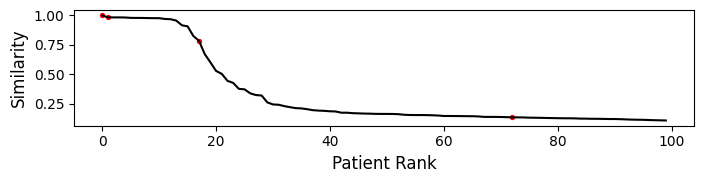

In [25]:
template_patient_index = patient_ids_d.index(template_patient_id) # The index of the template patient in the similarity matrix
Similarities_sorted = np.sort(Similarity_matrix[template_patient_index, :])[::-1] # Sort the similarities in descending order
Representative_patient_ids = ['MB-0262', 'MB-0356', 'MB-0290']
f, ax = plt.subplots(figsize=(8, 1.5))
ax.plot(Similarities_sorted[:100], color="k")
# TEMPLATE PATIENT
ax.scatter(0, Similarities_sorted[0], color="red", s=8)
# REPRESENTATIVE PATIENTS
Representative_patient_indices = (
    patient_ids_d.index(Representative_patient_ids[0]),
    patient_ids_d.index(Representative_patient_ids[1]),
    patient_ids_d.index(Representative_patient_ids[2]),
)
Patient_indices_sorted = np.argsort(Similarity_matrix[template_patient_index, :])[::-1]
Representative_patient_rankings = [
    list(Patient_indices_sorted).index(i) for i in Representative_patient_indices
]
for indice in Representative_patient_rankings:
    ax.scatter(indice, Similarities_sorted[indice], color="red", s=8)
    print("Patient ID:", patient_ids_d[indice], "Similarity:", Similarities_sorted[indice], "Rank:", indice)
ax.set_xlabel("Patient Rank", fontsize=12)
ax.set_ylabel("Similarity", fontsize=12)
plt.show()

### Fig.5.c A representative example


The image ID of the patient MB-0262 is 145
The number of cells in the template patient is 1652


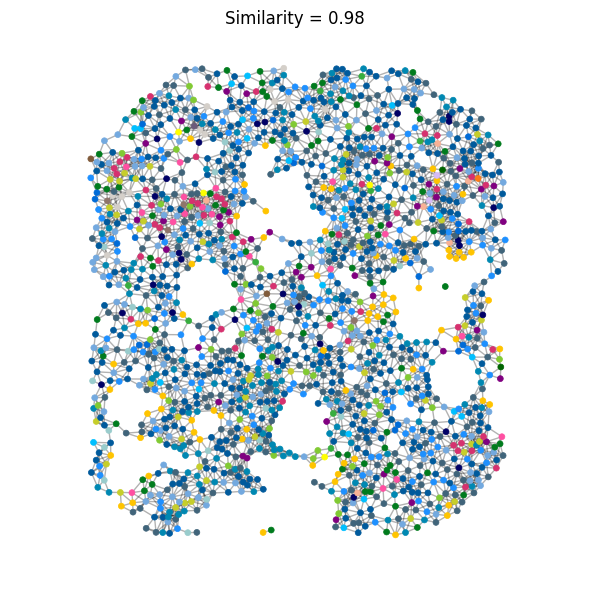

In [26]:
patient_id = "MB-0262"
image_id = SC_d[SC_d["patientID"] == patient_id]["imageID"].values[0]
print("The image ID of the patient", patient_id, "is", image_id)
adj = Cellular_graphs[patient_ids_d.index(patient_id)][1] # The adjacency matrix of the template patient
cells_ = SC_d[SC_d['imageID'] == image_id].reset_index(drop=True)
assert len(cells_) == adj.shape[0]
print("The number of cells in the template patient is", len(cells_))
np.fill_diagonal(adj, 0) # Remove self loops
adj[adj < 0.01] = 0
G = nx.from_numpy_array(adj)
nx.set_node_attributes(G, cells_["coorX"], "coorX")
nx.set_node_attributes(G, cells_["coorY"], "coorY")
nx.set_node_attributes(G, cells_["meta_description"], "meta_description")
f, ax = plt.subplots(
    1,
    1,
    figsize=(6, 6),
    tight_layout=True,
)
cell_color_dict = get_node_color("Danenberg", "CellType")
nx.draw_networkx_nodes(
    G,
    get_pos(G),
    node_size=18,
    node_color=[
        cell_color_dict[cell_type]
        for cell_type in list(nx.get_node_attributes(G, "meta_description").values())
    ],
    # edgecolors="black",
    linewidths=0.5,
    ax=ax,
)
nx.draw_networkx_edges(G, get_pos(G), ax=ax, alpha=0.3, width=1)
ax.set(
    title = 'Similarity = {:.2f}'.format(Similarity_matrix[template_patient_index, patient_ids_d.index(patient_id)]),
    xlim=(
        (max(cells_["coorX"]) - min(cells_["coorX"])) / 2 - 350,
        (max(cells_["coorX"]) - min(cells_["coorX"])) / 2 + 350,
    ),
    ylim=(
        (max(cells_["coorY"]) - min(cells_["coorY"])) / 2 - 350,
        (max(cells_["coorY"]) - min(cells_["coorY"])) / 2 + 350,
    ),
)
ax.set_axis_off()

### Fig.5.d A representative example

The image ID of the patient MB-0356 is 41
The number of cells in the template patient is 1244


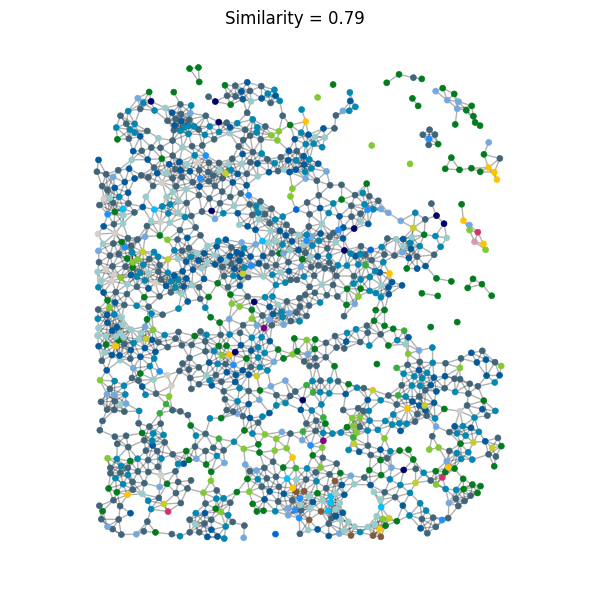

In [27]:
patient_id = "MB-0356"
image_id = SC_d[SC_d["patientID"] == patient_id]["imageID"].values[0]
print("The image ID of the patient", patient_id, "is", image_id)
adj = Cellular_graphs[patient_ids_d.index(patient_id)][1] # The adjacency matrix of the template patient
cells_ = SC_d[SC_d['imageID'] == image_id].reset_index(drop=True)
assert len(cells_) == adj.shape[0]
print("The number of cells in the template patient is", len(cells_))
np.fill_diagonal(adj, 0) # Remove self loops
adj[adj < 0.01] = 0
G = nx.from_numpy_array(adj)
nx.set_node_attributes(G, cells_["coorX"], "coorX")
nx.set_node_attributes(G, cells_["coorY"], "coorY")
nx.set_node_attributes(G, cells_["meta_description"], "meta_description")
f, ax = plt.subplots(
    1,
    1,
    figsize=(6, 6),
    tight_layout=True,
)
cell_color_dict = get_node_color("Danenberg", "CellType")
nx.draw_networkx_nodes(
    G,
    get_pos(G),
    node_size=18,
    node_color=[
        cell_color_dict[cell_type]
        for cell_type in list(nx.get_node_attributes(G, "meta_description").values())
    ],
    # edgecolors="black",
    linewidths=0.5,
    ax=ax,
)
nx.draw_networkx_edges(G, get_pos(G), ax=ax, alpha=0.3, width=1)
ax.set(
    title = 'Similarity = {:.2f}'.format(Similarity_matrix[template_patient_index, patient_ids_d.index(patient_id)]),
    xlim=(
        (max(cells_["coorX"]) - min(cells_["coorX"])) / 2 - 350,
        (max(cells_["coorX"]) - min(cells_["coorX"])) / 2 + 350,
    ),
    ylim=(
        (max(cells_["coorY"]) - min(cells_["coorY"])) / 2 - 350,
        (max(cells_["coorY"]) - min(cells_["coorY"])) / 2 + 350,
    ),
)
ax.set_axis_off()

### Fig.5.e A Representative Example

The image ID of the patient MB-0290 is 199
The number of cells in the template patient is 1348


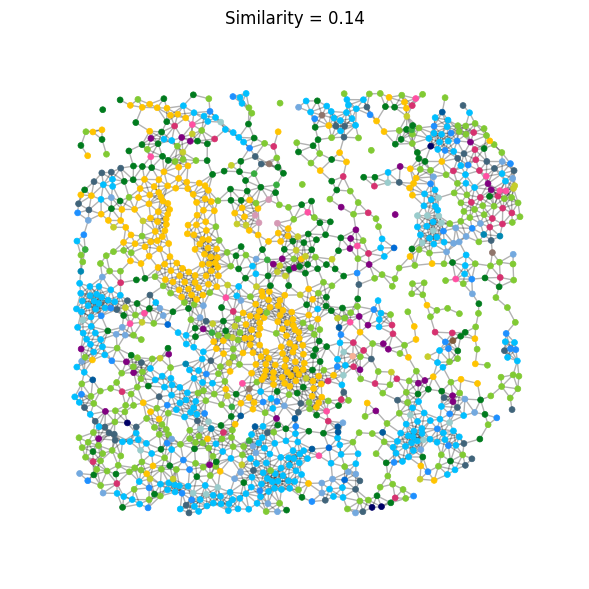

In [28]:
patient_id = "MB-0290"
image_id = SC_d[SC_d["patientID"] == patient_id]["imageID"].values[0]
print("The image ID of the patient", patient_id, "is", image_id)
adj = Cellular_graphs[patient_ids_d.index(patient_id)][1] # The adjacency matrix of the template patient
cells_ = SC_d[SC_d['imageID'] == image_id].reset_index(drop=True)
assert len(cells_) == adj.shape[0]
print("The number of cells in the template patient is", len(cells_))
np.fill_diagonal(adj, 0) # Remove self loops
adj[adj < 0.01] = 0
G = nx.from_numpy_array(adj)
nx.set_node_attributes(G, cells_["coorX"], "coorX")
nx.set_node_attributes(G, cells_["coorY"], "coorY")
nx.set_node_attributes(G, cells_["meta_description"], "meta_description")
f, ax = plt.subplots(
    1,
    1,
    figsize=(6, 6),
    tight_layout=True,
)
cell_color_dict = get_node_color("Danenberg", "CellType")
nx.draw_networkx_nodes(
    G,
    get_pos(G),
    node_size=18,
    node_color=[
        cell_color_dict[cell_type]
        for cell_type in list(nx.get_node_attributes(G, "meta_description").values())
    ],
    # edgecolors="black",
    linewidths=0.5,
    ax=ax,
)
nx.draw_networkx_edges(G, get_pos(G), ax=ax, alpha=0.3, width=1)
ax.set(
    title = 'Similarity = {:.2f}'.format(Similarity_matrix[template_patient_index, patient_ids_d.index(patient_id)]),
    xlim=(
        (max(cells_["coorX"]) - min(cells_["coorX"])) / 2 - 350,
        (max(cells_["coorX"]) - min(cells_["coorX"])) / 2 + 350,
    ),
    ylim=(
        (max(cells_["coorY"]) - min(cells_["coorY"])) / 2 - 350,
        (max(cells_["coorY"]) - min(cells_["coorY"])) / 2 + 350,
    ),
)
ax.set_axis_off()

## Fig.6 Population graph and patient subgroups

In [57]:
patient_ids_discovery = list(SC_d["patientID"].unique())
subgroup_ids_discovery = np.zeros(len(patient_ids_discovery), dtype=object)
subgroup_ids_discovery[:] = "Unclassified"
for i in range(len( patient_subgroups_discovery)):
    subgroup = patient_subgroups_discovery[i]
    subgroup_id = subgroup["subgroup_id"]
    patient_ids = subgroup["patient_ids"]
    subgroup_ids_discovery[np.isin(patient_ids_discovery, patient_ids)] = subgroup_id

### Fig.6.a Visualize population graph painted with patient subgroup ids

In [58]:
color_palette_Bigraph = {
    "Unclassified": "white",
    "S1": sns.color_palette("tab10")[0],
    "S2": sns.color_palette("tab10")[1],
    "S3": sns.color_palette("tab10")[2],
    "S4": sns.color_palette("tab10")[3],
    "S5": sns.color_palette("tab10")[4],
    "S6": sns.color_palette("tab10")[5],
    "S7": sns.color_palette("tab10")[6],
    "S8": sns.color_palette("tab10")[7],
    "S9": sns.color_palette("tab10")[8],
    "S10": sns.color_palette("tab10")[9],
}

Initialized Population_Graph, k_clustering =  20 , k_estimate =  3 , resolution =  1.0 , size_smallest_cluster =  10 , seed =  1


[[Text(-0.8, 0, ''),
  Text(-0.6000000000000001, 0, ''),
  Text(-0.4, 0, ''),
  Text(-0.19999999999999996, 0, ''),
  Text(0.0, 0, ''),
  Text(0.19999999999999996, 0, ''),
  Text(0.40000000000000013, 0, ''),
  Text(0.6000000000000001, 0, ''),
  Text(0.8, 0, ''),
  Text(1.0, 0, '')],
 [Text(-1.0, 0, ''),
  Text(-0.8, 0, ''),
  Text(-0.6, 0, ''),
  Text(-0.3999999999999999, 0, ''),
  Text(-0.19999999999999996, 0, ''),
  Text(0.0, 0, ''),
  Text(0.20000000000000018, 0, ''),
  Text(0.40000000000000013, 0, ''),
  Text(0.6000000000000001, 0, ''),
  Text(0.8, 0, '')],
 [Text(-0.8, 0, ''),
  Text(-0.6000000000000001, 0, ''),
  Text(-0.4, 0, ''),
  Text(-0.19999999999999996, 0, ''),
  Text(0.0, 0, ''),
  Text(0.19999999999999996, 0, ''),
  Text(0.40000000000000013, 0, ''),
  Text(0.6000000000000001, 0, ''),
  Text(0.8, 0, '')]]

/cis/home/zwang/venv/cell-gnn/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/cis/home/zwang/venv/cell-gnn/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  func(*args, **kwargs)
/cis/home/zwang/venv/cell-gnn/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


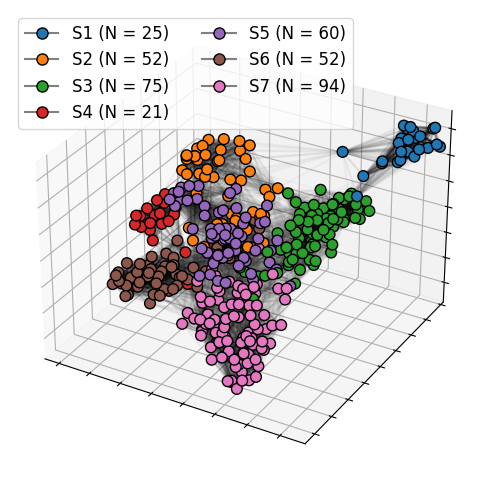

In [59]:

# For visualization purpose, we make nodes distant from each other
population_graph_for_visualization  = Population_Graph(
    k_clustering=20
).generate(
    bigraph_.Similarity_matrix, patient_ids_discovery
)  # generate population graph
pos = nx.spring_layout(
    population_graph_for_visualization,
    seed=3,
    k=1 / (np.sqrt(397)) * 10,
    iterations=100,
    dim=3,
)
fig = plt.figure(figsize=(5, 5), tight_layout=True)
ax = fig.add_subplot(111, projection="3d")
node_xyz = np.array([pos[v] for v in sorted(population_graph_for_visualization)])
edge_xyz = np.array([(pos[u], pos[v]) for u, v in population_graph_for_visualization.edges()])
ax.scatter(
    *node_xyz.T,
    s=60,
    c=[color_palette_Bigraph[i] for i in subgroup_ids_discovery],
    edgecolors="black",
    linewidths=1,
    alpha=1
)
edge_list = list(population_graph_for_visualization.edges())
edge_alpha = [
    (
        0.2 * population_graph_for_visualization[u][v]["weight"]
        if population_graph_for_visualization[u][v]["weight"] > 0.1
        else 0
    )
    for u, v in edge_list
]
for i in range(len(edge_list)):
    u, v = edge_list[i]
    ax.plot(*edge_xyz[i].T, alpha=edge_alpha[i], color="k")

ax.set(
    xlim=(np.min(node_xyz[:, 0]), np.max(node_xyz[:, 0])),
    ylim=(np.min(node_xyz[:, 1]), np.max(node_xyz[:, 1])),
    zlim=(np.min(node_xyz[:, 2]), np.max(node_xyz[:, 2])),
)
handles = []
if np.sum(subgroup_ids_discovery == "Unclassified") > 0:
    handles.append(
        Line2D(
            [0],
            [0],
            marker="o",
            color="white",
            markerfacecolor="white",
            label="Unclassified (N = {})".format(
                np.sum(subgroup_ids_discovery == "Unclassified")
            ),
            markeredgecolor="black",
            markeredgewidth=1,
            markersize=8,
        )
    )
for subgroup in patient_subgroups_discovery:
    subgroup_id = subgroup["subgroup_id"]
    handles.append(
        Line2D(
            [0],
            [0],
            marker="o",
            color="grey",
            markerfacecolor=color_palette_Bigraph[subgroup_id],
            label="{} (N = {})".format(
                subgroup_id, np.sum(subgroup_ids_discovery == subgroup_id)
            ),
            markeredgecolor="black",
            markeredgewidth=1,
            markersize=8,
        )
    )

ax.legend(handles=handles, fontsize=12, ncols=2)
ax.set(yticklabels=[], xticklabels=[], zticklabels=[])


### Fig.6.b Plot Survival curves of patient subgroups

Patient subgroup S1: N = 25, HR = 2.28 (1.33-3.91), p = 2.82e-03
Patient subgroup S2: N = 52, HR = 1.80 (1.16-2.78), p = 8.60e-03
Patient subgroup S3: N = 75, HR = 1.29 (0.86-1.94), p = 2.11e-01
Patient subgroup S4: N = 21, HR = 1.17 (0.54-2.50), p = 6.92e-01
Patient subgroup S5: N = 60, HR = 0.86 (0.53-1.38), p = 5.29e-01
Patient subgroup S6: N = 52, HR = 0.53 (0.28-1.01), p = 5.20e-02
Patient subgroup S7: N = 94, HR = 0.51 (0.32-0.83), p = 6.38e-03


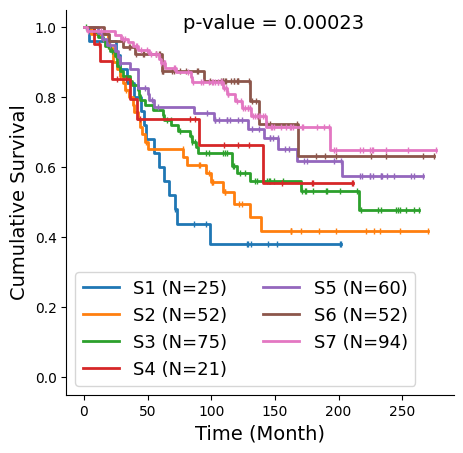

In [60]:
for i in range(len(patient_subgroups_discovery)):
    print(
        "Patient subgroup {}: N = {}, HR = {:.2f} ({:.2f}-{:.2f}), p = {:.2e}".format(
            patient_subgroups_discovery[i]["subgroup_id"],
            len(patient_subgroups_discovery[i]["patient_ids"]),
            patient_subgroups_discovery[i]["hr"],
            patient_subgroups_discovery[i]["hr_lower"],
            patient_subgroups_discovery[i]["hr_upper"],
            patient_subgroups_discovery[i]["p"],
        )
    )

lengths_discovery = [
    survival_d.loc[survival_d["patientID"] == i, "time"].values[0]
    for i in patient_ids_discovery
]
statuses_discovery = [
    (survival_d.loc[survival_d["patientID"] == i, "status"].values[0])
    for i in patient_ids_discovery
]
kmf = KaplanMeierFitter()
f, ax = plt.subplots(figsize=(5, 5))
for subgroup in patient_subgroups_discovery:
    subgroup_id = subgroup["subgroup_id"]
    length_A, event_observed_A = (
        np.array(lengths_discovery)[subgroup_ids_discovery == subgroup_id],
        np.array(statuses_discovery)[subgroup_ids_discovery == subgroup_id],
    )
    label = "{} (N={})".format(
        subgroup["subgroup_id"], np.sum(subgroup_ids_discovery == subgroup_id)
    )
    kmf.fit(length_A, event_observed_A, label=label)
    kmf.plot_survival_function(
        ax=ax,
        ci_show=False,
        color=color_palette_Bigraph[subgroup_id],
        show_censors=True,
        linewidth=2,
        censor_styles={"ms": 5, "marker": "|"},
    )
log_rank_test = multivariate_logrank_test(
    np.array(lengths_discovery)[subgroup_ids_discovery != 0],
    np.array(subgroup_ids_discovery)[subgroup_ids_discovery != 0],
    np.array(statuses_discovery)[subgroup_ids_discovery != 0],
)
p_value = log_rank_test.p_value
ax.legend(ncol=2, fontsize=13)
ax.text(
    x=0.3,
    y=0.95,
    s="p-value = {:.5f}".format(p_value),
    fontsize=14,
    transform=ax.transAxes,
)
ax.set_xlabel("Time (Month)", fontsize=14)
ax.set_ylabel("Cumulative Survival", fontsize=14)
ax.set(
    ylim=(-0.05, 1.05),
)
sns.despine()

### Fig.6.c Plot hazard ratios of patient subgroups

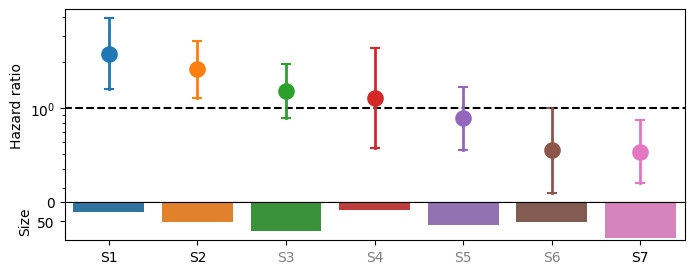

In [61]:
# Plot hazard ratio
f, ax = plt.subplots(2, 1, height_ratios=[5, 1], figsize=(8, 3), sharex=True)
f.subplots_adjust(hspace=0)
ax[0].hlines(1, -1, len(patient_subgroups_discovery), color="k", linestyle="--")
N, xticklabels, xtickcolors = [], [], []
for i in range(len(patient_subgroups_discovery)):
    subgroup = patient_subgroups_discovery[i]
    subgroup_id = subgroup['subgroup_id']
    hr, hr_lb, hr_ub, p = (
            subgroup["hr"],
            subgroup["hr_lower"],
            subgroup["hr_upper"],
            subgroup["p"],
        )
    ax[0].plot([i, i], [hr_lb, hr_ub], color=color_palette_Bigraph[subgroup_id], linewidth=2)
    ax[0].scatter([i], [hr], color=color_palette_Bigraph[subgroup_id], s=120)
    ax[0].scatter([i], [hr_lb], color=color_palette_Bigraph[subgroup_id], s=60, marker="_")
    ax[0].scatter([i], [hr_ub], color=color_palette_Bigraph[subgroup_id], s=60, marker="_")
    N.append(np.sum(subgroup_ids_discovery == subgroup_id))
    xticklabels.append("{}".format(subgroup_id))
    if p < 0.05:
        xtickcolors.append("k")
    else:
        xtickcolors.append("grey")
ax[0].set_xticks(range(len(patient_subgroups_discovery)))
ax[0].set_xticklabels(xticklabels)
for xtick, color in zip(ax[1].get_xticklabels(), xtickcolors):
    xtick.set_color(color)
ax[0].set_xlabel("Patient Subgroups")
ax[0].set_ylabel("Hazard ratio")
ax[0].set_yscale("log")
DF = pd.DataFrame({"N": N, "subgroup_id": xticklabels})
g = sns.barplot(data=DF, x="subgroup_id", y="N", palette=color_palette_Bigraph, ax=ax[1])
g.invert_yaxis()
ax[1].set_ylabel("Size")
ax[1].set_xlabel("")
plt.show()

## Fig.7 Correlate BiGraph-derived subgroups with Clinical subgroups

### Extract clinical subtype for each patient

In [62]:
patient_ids_discovery = list(SC_d["patientID"].unique())
subgroup_ids_discovery = np.zeros(len(patient_ids_discovery), dtype=object)
subgroup_ids_discovery[:] = "Unclassified"
for i in range(len( patient_subgroups_discovery)):
    subgroup = patient_subgroups_discovery[i]
    subgroup_id = subgroup["subgroup_id"]
    patient_ids = subgroup["patient_ids"]
    subgroup_ids_discovery[np.isin(patient_ids_discovery, patient_ids)] = subgroup_id
clinical_subtypes_discovery = np.zeros(len(patient_ids_discovery), dtype=object)
clinical_subtypes_discovery[:] = 'Unknown'
for i in range(len(patient_ids_discovery)):
    patient_id = patient_ids_discovery[i]
    er = survival_d.loc[survival_d['patientID'] == patient_id, 'ER Status'].values[0]
    pr = survival_d.loc[survival_d['patientID'] == patient_id, 'PR Status'].values[0]
    her2 = survival_d.loc[survival_d['patientID'] == patient_id, 'HER2 Status'].values[0]
    if  her2 == "Positive":
        clinical_subtypes_discovery[i] = 'HER2+' # Her2+
    if (er == "Positive" or pr == "Positive") and her2 == "Negative":
        clinical_subtypes_discovery[i] = 'HR+/HER2-' # HR+/HER2-
    elif (er == "Negative" and pr == "Negative") and her2 == "Negative":
        clinical_subtypes_discovery[i] = 'TNBC' # TNBC
print(
    "{} patients in total, {} Unkonw, {} HER2+, {} HR+/HER2-, {} TNBC".format(
        len(clinical_subtypes_discovery),
              np.sum(clinical_subtypes_discovery == 'Unknown'),
        np.sum(clinical_subtypes_discovery == 'HER2+'),
        np.sum(clinical_subtypes_discovery == 'HR+/HER2-'),
        np.sum(clinical_subtypes_discovery == 'TNBC'),
  

    )
)

379 patients in total, 54 Unkonw, 32 HER2+, 243 HR+/HER2-, 50 TNBC


###  Table 1: Averaged inter-patient similarity

In [63]:
def caculate_mutual_similarity(gram_matrix):
    gram_matrix_ = gram_matrix.copy()
    np.fill_diagonal(gram_matrix_, -1)
    return np.mean(gram_matrix_[gram_matrix_ != -1])


Similarity_matrix = bigraph_.Similarity_matrix
print(
    "The mutual similarity of the population graph is {:.2f}".format(
        caculate_mutual_similarity(Similarity_matrix)
    )
)

Gram_matrix_ = Similarity_matrix[
    np.array(np.where(clinical_subtypes_discovery == 'HER2+')[0].tolist()), :
][:, np.array(np.where(clinical_subtypes_discovery == 'HER2+')[0].tolist())]
print(
    "{} HER2+ patients, averaged Intra-group similarity is {:.2f} ".format(
        Gram_matrix_.shape[0], caculate_mutual_similarity(Gram_matrix_)
    )
)

Gram_matrix_ = Similarity_matrix[
    np.array(np.where(clinical_subtypes_discovery == 'HR+/HER2-')[0].tolist()), :
][:, np.array(np.where(clinical_subtypes_discovery == 'HR+/HER2-')[0].tolist())]
print(
    "{} HR+/HER2- patients, averaged Intra-group similarity is {:.2f} ".format(
        Gram_matrix_.shape[0], caculate_mutual_similarity(Gram_matrix_)
    )
)

Gram_matrix_ = Similarity_matrix[
    np.array(np.where(clinical_subtypes_discovery == 'TNBC')[0].tolist()), :
][:, np.array(np.where(clinical_subtypes_discovery == 'TNBC')[0].tolist())]
print(
    "{} TNBC patients, averaged Intra-group similarity is {:.2f} ".format(
        Gram_matrix_.shape[0], caculate_mutual_similarity(Gram_matrix_)
    )
)

The mutual similarity of the population graph is 0.18
32 HER2+ patients, averaged Intra-group similarity is 0.43 
243 HR+/HER2- patients, averaged Intra-group similarity is 0.20 
50 TNBC patients, averaged Intra-group similarity is 0.15 


In [64]:
intra_cluster_similarity = 0
for subgroup_id in [
    "S" + str(i) for i in range(1, len(patient_subgroups_discovery) + 1)
]:
    Gram_matrix_ = Similarity_matrix[
        np.array(np.where(subgroup_ids_discovery == subgroup_id)[0].tolist()), :
    ][:, np.array(np.where(subgroup_ids_discovery == subgroup_id)[0].tolist())]
    intra_cluster_similarity += np.sum(Gram_matrix_)
    print(
        "{} patients in {}, averaged Intra-group similarity is {:.2f} ".format(
            subgroup_id, Gram_matrix_.shape[0], caculate_mutual_similarity(Gram_matrix_)
        )
    )
inter_cluster_similarity = np.sum(Similarity_matrix) - intra_cluster_similarity
print(
    "Intra-cluster similarity is {:.2f}, inter-cluster similarity = {:.2f}, ratio = {:.2f}".format(
        intra_cluster_similarity,
        inter_cluster_similarity,
        intra_cluster_similarity / inter_cluster_similarity,
    )
)

S1 patients in 25, averaged Intra-group similarity is 0.76 
S2 patients in 52, averaged Intra-group similarity is 0.25 
S3 patients in 75, averaged Intra-group similarity is 0.48 
S4 patients in 21, averaged Intra-group similarity is 0.83 
S5 patients in 60, averaged Intra-group similarity is 0.31 
S6 patients in 52, averaged Intra-group similarity is 0.54 
S7 patients in 94, averaged Intra-group similarity is 0.38 
Intra-cluster similarity is 10381.97, inter-cluster similarity = 15606.35, ratio = 0.67


### Fig 7.a Paint Population graph with clinical subtypes

Initialized Population_Graph, k_clustering =  20 , k_estimate =  3 , resolution =  1.0 , size_smallest_cluster =  10 , seed =  1


/cis/home/zwang/venv/cell-gnn/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1019: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asarray(x)


[[Text(-0.8, 0, ''),
  Text(-0.6000000000000001, 0, ''),
  Text(-0.4, 0, ''),
  Text(-0.19999999999999996, 0, ''),
  Text(0.0, 0, ''),
  Text(0.19999999999999996, 0, ''),
  Text(0.40000000000000013, 0, ''),
  Text(0.6000000000000001, 0, ''),
  Text(0.8, 0, ''),
  Text(1.0, 0, '')],
 [Text(-1.0, 0, ''),
  Text(-0.8, 0, ''),
  Text(-0.6, 0, ''),
  Text(-0.3999999999999999, 0, ''),
  Text(-0.19999999999999996, 0, ''),
  Text(0.0, 0, ''),
  Text(0.20000000000000018, 0, ''),
  Text(0.40000000000000013, 0, ''),
  Text(0.6000000000000001, 0, ''),
  Text(0.8, 0, '')],
 [Text(-0.8, 0, ''),
  Text(-0.6000000000000001, 0, ''),
  Text(-0.4, 0, ''),
  Text(-0.19999999999999996, 0, ''),
  Text(0.0, 0, ''),
  Text(0.19999999999999996, 0, ''),
  Text(0.40000000000000013, 0, ''),
  Text(0.6000000000000001, 0, ''),
  Text(0.8, 0, '')]]

/cis/home/zwang/venv/cell-gnn/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/cis/home/zwang/venv/cell-gnn/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  func(*args, **kwargs)


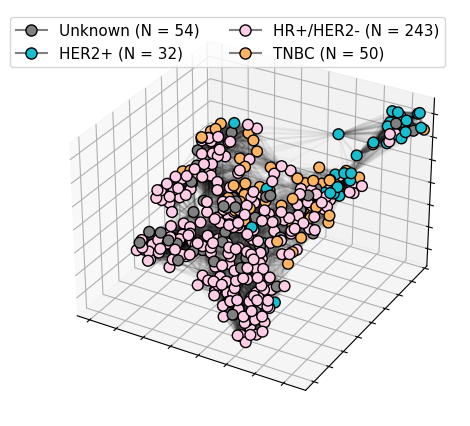

In [65]:
# For visualization purpose, we make nodes distant from each other
population_graph_for_visualization  = Population_Graph(
    k_clustering=20
).generate(
    bigraph_.Similarity_matrix, patient_ids_discovery
)  # generate population graph
pos = nx.spring_layout(
    population_graph_for_visualization,
    seed=3,
    k=1 / (np.sqrt(397)) * 10,
    iterations=100,
    dim=3,
)
fig = plt.figure(figsize=(5, 5), tight_layout=True)
ax = fig.add_subplot(111, projection="3d")
node_xyz = np.array([pos[v] for v in sorted(population_graph_for_visualization)])
edge_xyz = np.array([(pos[u], pos[v]) for u, v in population_graph_for_visualization.edges()])
ax.scatter(
    *node_xyz.T,
    s=60,
    c=[color_palette_clinical[i] for i in clinical_subtypes_discovery],
    edgecolors="black",
    linewidths=1,
    alpha=1
)
edge_list = list(population_graph_for_visualization.edges())
edge_alpha = [
    (
        0.2 * population_graph_for_visualization[u][v]["weight"]
        if population_graph_for_visualization[u][v]["weight"] > 0.1
        else 0
    )
    for u, v in edge_list
]
for i in range(len(edge_list)):
    u, v = edge_list[i]
    ax.plot(*edge_xyz[i].T, alpha=edge_alpha[i], color="k")

ax.set(
    xlim=(np.min(node_xyz[:, 0]), np.max(node_xyz[:, 0])),
    ylim=(np.min(node_xyz[:, 1]), np.max(node_xyz[:, 1])),
    zlim=(np.min(node_xyz[:, 2]), np.max(node_xyz[:, 2])),
)
handles = []
for clinical_subtype_id in ['Unknown', 'HER2+', 'HR+/HER2-', 'TNBC']:
    handles.append(
        Line2D(
            [0],
            [0],
            marker="o",
            color="grey",
            markerfacecolor=color_palette_clinical[clinical_subtype_id],
            label="{} (N = {})".format(
                clinical_subtype_id, np.sum(clinical_subtypes_discovery == clinical_subtype_id)
            ),
            markeredgecolor="black",
            markeredgewidth=1,
            markersize=8,
        )
    )

ax.legend(handles=handles, fontsize=11, ncols=2)
ax.set(yticklabels=[], xticklabels=[], zticklabels=[])


### Fig.7.c Spearmanr correlation 

Clinical Subtype: HER2+, Subgroup: S1, correlation_coefficient: 0.61, p_val: 1.35e-39
Clinical Subtype: TNBC, Subgroup: S2, correlation_coefficient: 0.23, p_val: 6.21e-06
Clinical Subtype: TNBC, Subgroup: S3, correlation_coefficient: 0.18, p_val: 4.91e-04
Clinical Subtype: TNBC, Subgroup: S7, correlation_coefficient: -0.19, p_val: 2.37e-04
Clinical Subtype: HR+/HER2-, Subgroup: S1, correlation_coefficient: -0.27, p_val: 1.38e-07
Clinical Subtype: HR+/HER2-, Subgroup: S7, correlation_coefficient: 0.20, p_val: 8.57e-05


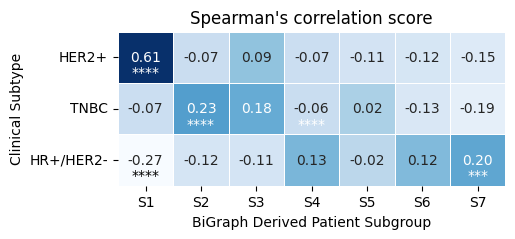

In [66]:
import numpy as np

spearmanr_corr = np.zeros((3, 7))
P_value = np.zeros((3, 7))
for i in range(3):
    clinical_subtype = ["HER2+", "TNBC", "HR+/HER2-"][i]
    for j in range(7):
        subgroup_id = ["S1", "S2", "S3", "S4", "S5", "S6", "S7"][j]
        variable_1 = (np.array(clinical_subtypes_discovery) == clinical_subtype) 
        variable_2 = (np.array(subgroup_ids_discovery) == subgroup_id)
        correlation_coefficient, p_value = spearmanr(variable_1, variable_2)
        spearmanr_corr[i,j] = correlation_coefficient
        P_value[i,j] = p_value
        if p_value < 0.05/(3*7):
            print(
                    "Clinical Subtype: {}, Subgroup: {}, correlation_coefficient: {:.2f}, p_val: {:.2e}".format(
                        clinical_subtype, subgroup_id, correlation_coefficient, p_value
                    )
                )

       
f, ax = plt.subplots(figsize=(5, 2))
sns.heatmap(spearmanr_corr, annot=True, fmt=".2f", cmap="Blues", cbar = False, linewidths=0.5, linecolor='white', ax=ax, vmax = 0.6)
ax.text(0 + 0.5, 0+0.8 , '****',
                 horizontalalignment='center',
                 verticalalignment='center',
                 color = 'white'
                 )
ax.text(0 + 0.5, 2+0.8 , '****',
                 horizontalalignment='center',
                 verticalalignment='center',
                 color = 'black'
                 )

ax.text(1 + 0.5, 1+0.8 , '****',
                 horizontalalignment='center',
                 verticalalignment='center',
                 color = 'white'
                 )
ax.text(3 + 0.5, 1+0.8 , '****',
                 horizontalalignment='center',
                 verticalalignment='center',
                 color = 'white'
                 )

ax.text(6 + 0.5, 2+0.8 , '***',
                 horizontalalignment='center',
                 verticalalignment='center',
                 color = 'white'
                 )


ax.set_xlabel("BiGraph Derived Patient Subgroup")
ax.set_ylabel("Clinical Subtype")
ax.set_xticklabels(["S1", "S2", "S3", "S4", "S5", "S6", "S7"] ,rotation=0)
ax.set_yticklabels(["HER2+", "TNBC", "HR+/HER2-"], rotation=0)
ax.set(title = "Spearman's correlation score")
plt.show()

## Fig.8 BiGraph enhances the risk stratification of clinical subtype 

### Fig.8.a HER2+ and S1

     test_statistic         p   -log2(p)
1 2        5.477862  0.019259   5.698338
  3       12.007286  0.000530  10.881912
2 3        0.136284  0.712004   0.490043


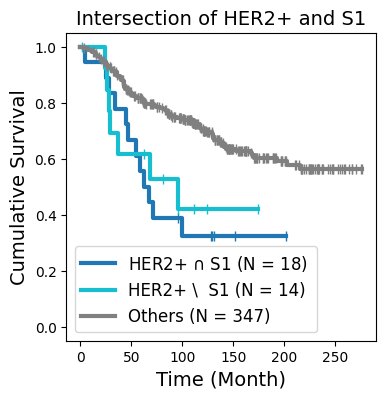

In [67]:
clinical_subtype = "HER2+"
subgroup_id = 'S1'
lengths_discovery = np.array(lengths_discovery)
statuses_discovery = np.array(statuses_discovery)
f, ax = plt.subplots(figsize=(4,4))
kmf = KaplanMeierFitter()
Indices_A = (subgroup_ids_discovery == subgroup_id) & (clinical_subtypes_discovery == clinical_subtype)
length_A, event_observed_A = (
    lengths_discovery[Indices_A],
    statuses_discovery[Indices_A],
)
label = r"{} $\cap$ {} (N = {}) ".format(clinical_subtype, subgroup_id, len(length_A))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(
    ax=ax,
    ci_show=False,
    color=color_palette_Bigraph[subgroup_id],
    show_censors=True,
    censor_styles={"ms": 7, "marker": "|"},
    markerfacecolor="grey",
    linewidth=3,
    label=label,
)

Indices_C = (subgroup_ids_discovery != subgroup_id) & (clinical_subtypes_discovery == clinical_subtype)
length_C, event_observed_C = (
    lengths_discovery[Indices_C],
    statuses_discovery[Indices_C],
)
label = r"{} \  {} (N = {}) ".format(clinical_subtype, subgroup_id, len(length_C))
kmf.fit(length_C, event_observed_C, label=label)
kmf.plot_survival_function(
    ax=ax,
    ci_show=False,
    color=color_palette_clinical[clinical_subtype],
    show_censors=True,
    censor_styles={"ms": 7, "marker": "|"},
    markerfacecolor="grey",

    linewidth=3,
)

Indices_B = (
    (clinical_subtypes_discovery != clinical_subtype)
)
length_B, event_observed_B = (
    lengths_discovery[Indices_B],
    statuses_discovery[Indices_B],
)
label = r"Others (N = {})".format(len(length_B))
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(
    ax=ax,
    ci_show=False,
    color="grey",
    show_censors=True,
    censor_styles={"ms": 7, "marker": "|"},
    linewidth=3,
    label=label,  
)


groups = np.zeros_like(clinical_subtypes_discovery, dtype=int)
groups[:] = 1
groups[((clinical_subtypes_discovery == clinical_subtype)) & (subgroup_ids_discovery != subgroup_id)] = 2
groups[((clinical_subtypes_discovery == clinical_subtype)) & (subgroup_ids_discovery == subgroup_id)] = 3


log_rank_test = pairwise_logrank_test(
    lengths_discovery,
    groups,
    statuses_discovery,
)
print(log_rank_test.summary)


ax.legend(fontsize=12)
ax.set_xlabel("Time (Month)", fontsize=14)
ax.set_ylabel("Cumulative Survival", fontsize=14)
ax.set(
    ylim=(-0.05, 1.05),
)
ax.set_title("Intersection of {} and {}".format(clinical_subtype, subgroup_id), fontsize=14)
plt.show()

### Fig.8.b TNBC and S2

     test_statistic         p   -log2(p)
1 2        1.150671  0.283409   1.819044
  3       12.820089  0.000343  11.509851
2 3        2.354184  0.124947   3.000609


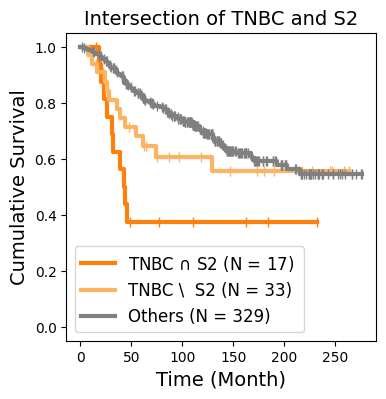

In [68]:
clinical_subtype = "TNBC"
subgroup_id = 'S2'
lengths_discovery = np.array(lengths_discovery)
statuses_discovery = np.array(statuses_discovery)
f, ax = plt.subplots(figsize=(4,4))
kmf = KaplanMeierFitter()
Indices_A = (subgroup_ids_discovery == subgroup_id) & (clinical_subtypes_discovery == clinical_subtype)
length_A, event_observed_A = (
    lengths_discovery[Indices_A],
    statuses_discovery[Indices_A],
)
label = r"{} $\cap$ {} (N = {}) ".format(clinical_subtype, subgroup_id, len(length_A))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(
    ax=ax,
    ci_show=False,
    color=color_palette_Bigraph[subgroup_id],
    show_censors=True,
    censor_styles={"ms": 7, "marker": "|"},
    markerfacecolor="grey",
    linewidth=3,
    label=label,
)

Indices_C = (subgroup_ids_discovery != subgroup_id) & (clinical_subtypes_discovery == clinical_subtype)
length_C, event_observed_C = (
    lengths_discovery[Indices_C],
    statuses_discovery[Indices_C],
)
label = r"{} \  {} (N = {}) ".format(clinical_subtype, subgroup_id, len(length_C))
kmf.fit(length_C, event_observed_C, label=label)
kmf.plot_survival_function(
    ax=ax,
    ci_show=False,
    color=color_palette_clinical[clinical_subtype],
    show_censors=True,
    censor_styles={"ms": 7, "marker": "|"},
    markerfacecolor="grey",

    linewidth=3,
)

Indices_B = (
    (clinical_subtypes_discovery != clinical_subtype)
)
length_B, event_observed_B = (
    lengths_discovery[Indices_B],
    statuses_discovery[Indices_B],
)
label = r"Others (N = {})".format(len(length_B))
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(
    ax=ax,
    ci_show=False,
    color="grey",
    show_censors=True,
    censor_styles={"ms": 7, "marker": "|"},
    linewidth=3,
    label=label,  
)


groups = np.zeros_like(clinical_subtypes_discovery, dtype=int)
groups[:] = 1
groups[((clinical_subtypes_discovery == clinical_subtype)) & (subgroup_ids_discovery != subgroup_id)] = 2
groups[((clinical_subtypes_discovery == clinical_subtype)) & (subgroup_ids_discovery == subgroup_id)] = 3


log_rank_test = pairwise_logrank_test(
    lengths_discovery,
    groups,
    statuses_discovery,
)
print(log_rank_test.summary)


ax.legend(fontsize=12)
ax.set_xlabel("Time (Month)", fontsize=14)
ax.set_ylabel("Cumulative Survival", fontsize=14)
ax.set(
    ylim=(-0.05, 1.05),
)
ax.set_title("Intersection of {} and {}".format(clinical_subtype, subgroup_id), fontsize=14)
plt.show()

### Fig.8.c HR+/HER2-+ and S7

     test_statistic         p   -log2(p)
1 2        4.225126  0.039830   4.650013
  3       11.375827  0.000744  10.392291
2 3        3.168599  0.075067   3.735681


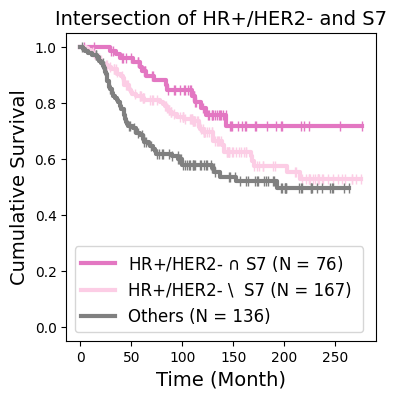

In [69]:
clinical_subtype = "HR+/HER2-"
subgroup_id = 'S7'
lengths_discovery = np.array(lengths_discovery)
statuses_discovery = np.array(statuses_discovery)
f, ax = plt.subplots(figsize=(4,4))
kmf = KaplanMeierFitter()
Indices_A = (subgroup_ids_discovery == subgroup_id) & (clinical_subtypes_discovery == clinical_subtype)
length_A, event_observed_A = (
    lengths_discovery[Indices_A],
    statuses_discovery[Indices_A],
)
label = r"{} $\cap$ {} (N = {}) ".format(clinical_subtype, subgroup_id, len(length_A))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(
    ax=ax,
    ci_show=False,
    color=color_palette_Bigraph[subgroup_id],
    show_censors=True,
    censor_styles={"ms": 7, "marker": "|"},
    markerfacecolor="grey",
    linewidth=3,
    label=label,
)

Indices_C = (subgroup_ids_discovery != subgroup_id) & (clinical_subtypes_discovery == clinical_subtype)
length_C, event_observed_C = (
    lengths_discovery[Indices_C],
    statuses_discovery[Indices_C],
)
label = r"{} \  {} (N = {}) ".format(clinical_subtype, subgroup_id, len(length_C))
kmf.fit(length_C, event_observed_C, label=label)
kmf.plot_survival_function(
    ax=ax,
    ci_show=False,
    color=color_palette_clinical[clinical_subtype],
    show_censors=True,
    censor_styles={"ms": 7, "marker": "|"},
    markerfacecolor="grey",

    linewidth=3,
)

Indices_B = (
    (clinical_subtypes_discovery != clinical_subtype)
)
length_B, event_observed_B = (
    lengths_discovery[Indices_B],
    statuses_discovery[Indices_B],
)
label = r"Others (N = {})".format(len(length_B))
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(
    ax=ax,
    ci_show=False,
    color="grey",
    show_censors=True,
    censor_styles={"ms": 7, "marker": "|"},
    linewidth=3,
    label=label,  
)


groups = np.zeros_like(clinical_subtypes_discovery, dtype=int)
groups[:] = 1
groups[((clinical_subtypes_discovery == clinical_subtype)) & (subgroup_ids_discovery != subgroup_id)] = 2
groups[((clinical_subtypes_discovery == clinical_subtype)) & (subgroup_ids_discovery == subgroup_id)] = 3


log_rank_test = pairwise_logrank_test(
    lengths_discovery,
    groups,
    statuses_discovery,
)
print(log_rank_test.summary)


ax.legend(fontsize=12)
ax.set_xlabel("Time (Month)", fontsize=14)
ax.set_ylabel("Cumulative Survival", fontsize=14)
ax.set(
    ylim=(-0.05, 1.05),
)
ax.set_title("Intersection of {} and {}".format(clinical_subtype, subgroup_id), fontsize=14)
plt.show()

##  Fig.9 Signature of characteristic patterns in each patient subgroup

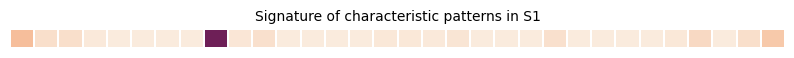

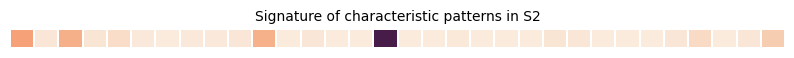

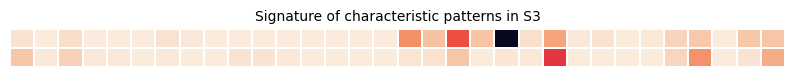

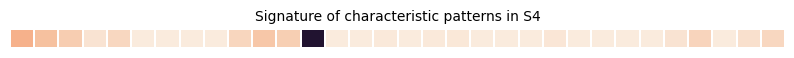

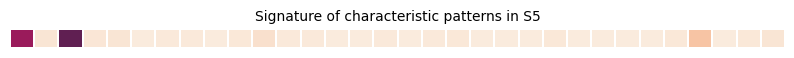

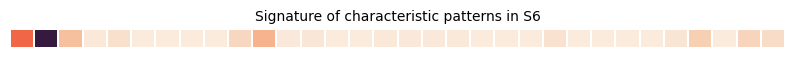

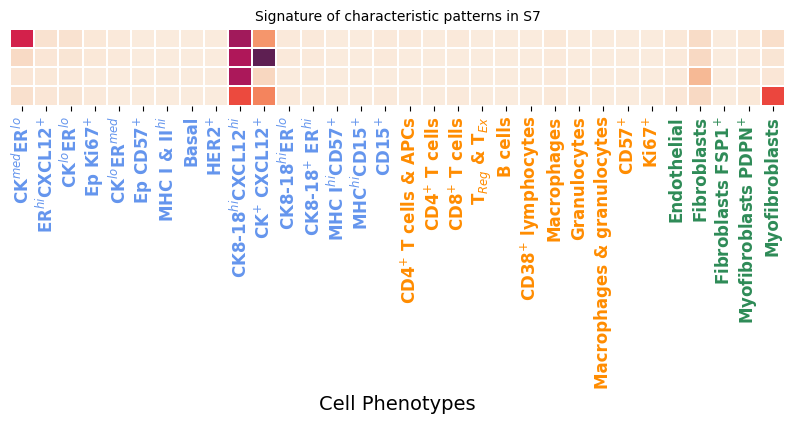

In [71]:
Signatures = bigraph_.fitted_soft_wl_subtree.Signatures
for i in range(len(patient_subgroups_discovery)):
    subgroup_id = patient_subgroups_discovery[i]["subgroup_id"]
    characteristic_patterns = patient_subgroups_discovery[i]["characteristic_patterns"]
    if len(characteristic_patterns) ==0:
        continue
    f, ax= plt.subplots(1,1,figsize=(10,0.25*len(characteristic_patterns)))
    sns.heatmap(
            Signatures[np.array(characteristic_patterns), :],
            ax=ax,
            cbar=False,
            cmap="rocket_r",
            linewidth=0.005,
            vmax=np.percentile(Signatures, 99),
            vmin=np.percentile(Signatures, 1),

        )
    ax.get_yaxis().set_visible(False)
    if subgroup_id == 'S7':
        ax.set_xticklabels(
            Cell_types_displayed_Danenberg, rotation=90, fontsize=12, fontweight="bold"
        )
        ax.set_xlabel("Cell Phenotypes", fontsize=14)
        xtickcolors = ["cornflowerblue"] * 16 + ["darkorange"] * 11 + ["seagreen"] * 5
        for xtick, color in zip(ax.get_xticklabels(), xtickcolors):
            xtick.set_color(color)
    else:
        ax.get_xaxis().set_visible(False)
    ax.set_title(f"Signature of characteristic patterns in {subgroup_id}", fontsize=10)
    plt.show()



## Fig.10 Representative examples of characteristic patterns in each patient subgroup. 

### Size distribution of cellular neighborhoods

In [72]:
Sizes = []
Distances = []
for i in range(len(bigraph_.fitted_soft_wl_subtree.X)):
    print(i)
    adj = bigraph_.fitted_soft_wl_subtree.X[i][1]
    adj_square = adj@adj
    Sizes.append(np.sum(adj_square > 0.01, axis = 1).flatten())
    distance = np.sqrt(-np.log(adj)/0.01)
    maxium_distance = [np.max(distance[i][adj_square[i] > 0.01]) for i in range(len(adj))]
    Distances.extend(maxium_distance)
Sizes = np.concatenate(Sizes)
Distances = np.array(Distances)
print(np.median(Sizes), np.median(Distances))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


KeyboardInterrupt: 

In [73]:
explainer_ = Explainer()
X_prime = bigraph_.fitted_soft_wl_subtree.X_prime
Signatures = bigraph_.fitted_soft_wl_subtree.Signatures

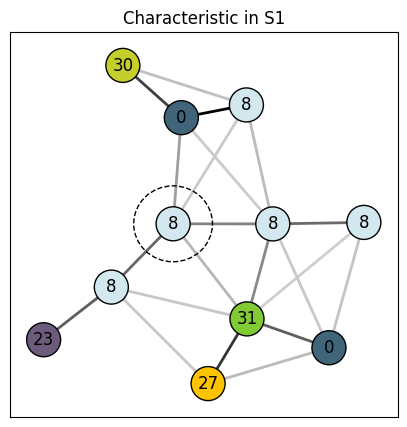

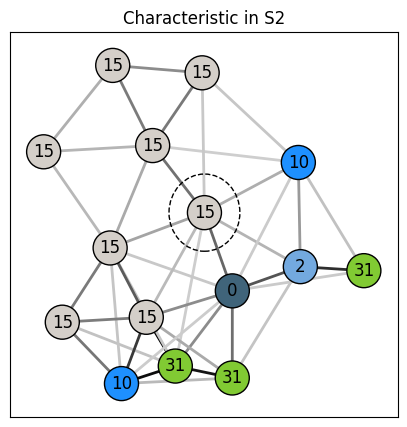

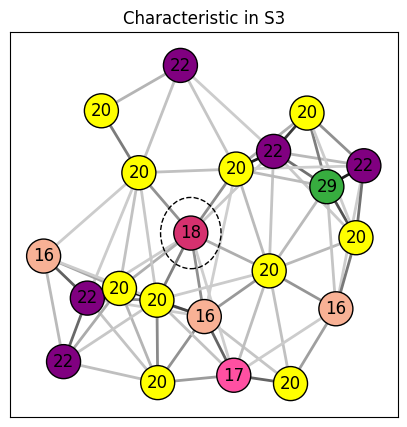

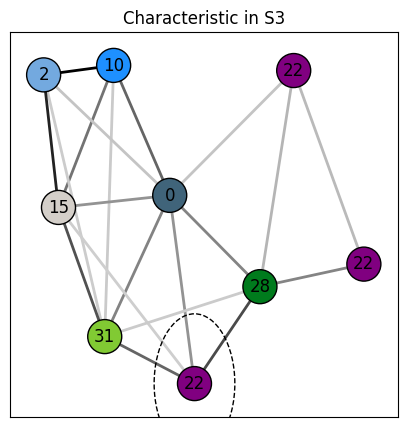

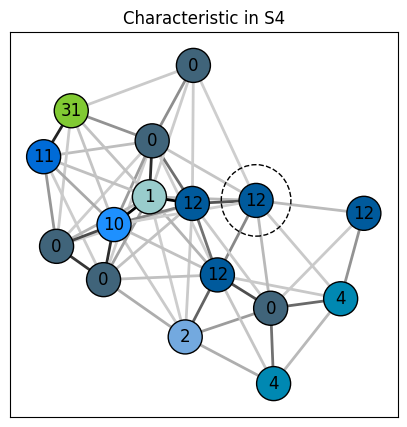

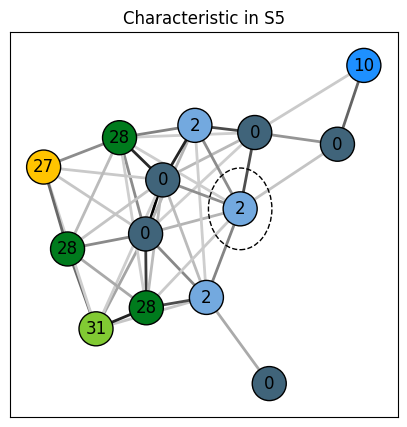

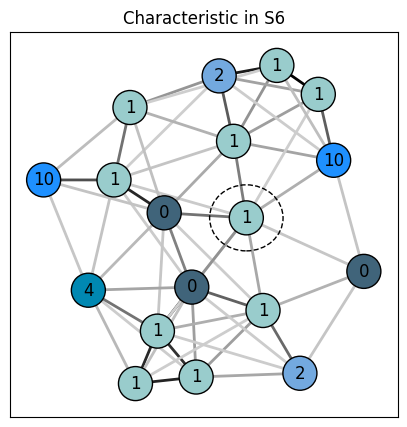

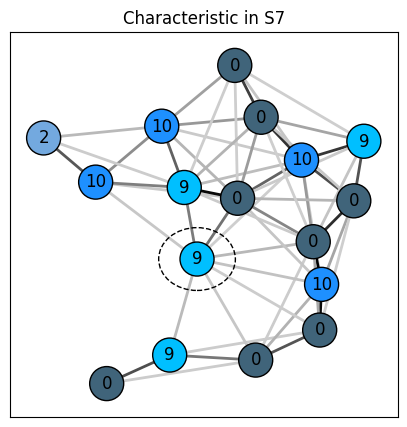

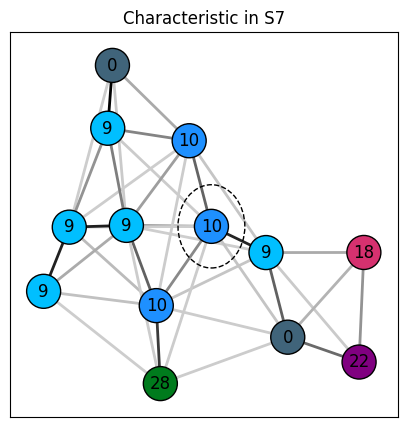

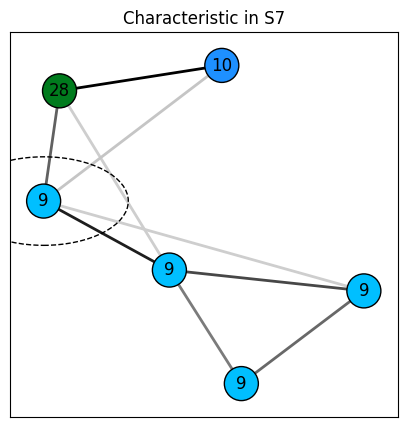

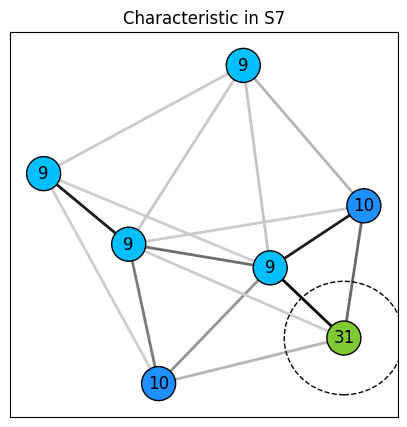

/cis/home/zwang/venv/cell-gnn/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


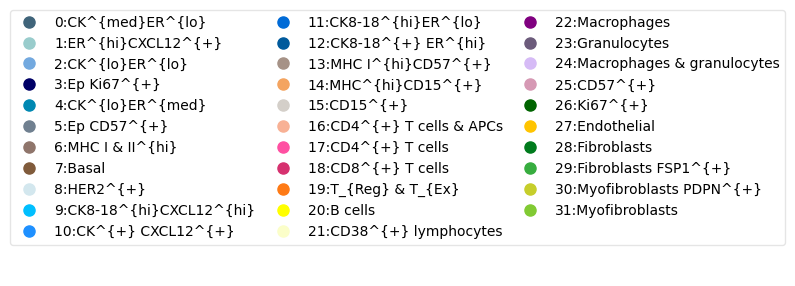

In [74]:
def get_pos(G):
    x = nx.get_node_attributes(G, "coorX")
    y = nx.get_node_attributes(G, "coorY")
    pos = {}
    for key, _ in x.items():
        pos[key] = (x[key], y[key])
    return pos


def normalize_pos(pos):
    x = np.array([pos[key][0] for key in pos.keys()])
    y = np.array([pos[key][1] for key in pos.keys()])
    x = x - np.mean(x)
    y = y - np.mean(y)
    pos_normalized = {}
    for i, key in enumerate(pos.keys()):
        pos_normalized[key] = (x[i], y[i])
    return pos_normalized


def decide_subtree_boundary(root_idx, Adj, iteration, boundary_weight_threshold=0.1):
    W = Adj.copy()
    for i in range(iteration):
        W = np.matmul(W, Adj)
    leaf_indices = list(np.where(W[root_idx, :] > boundary_weight_threshold)[0])
    return leaf_indices


for i in range(len(patient_subgroups_discovery)):
    subgroup_id = patient_subgroups_discovery[i]["subgroup_id"]
    characteristic_patterns = patient_subgroups_discovery[i]["characteristic_patterns"]
    for pattern_index in range(len(characteristic_patterns)):
        pattern_id = characteristic_patterns[pattern_index]
        representative_subtrees = explainer_.find_representative_subtrees(
            X_prime, Signatures, pattern_id, n=1
        )
        for patient_id, subtree_root_local_idx in representative_subtrees:
            adj = X_prime[patient_ids_discovery.index(patient_id)][1]
            subtree_leaves_local_idx = decide_subtree_boundary(
                subtree_root_local_idx, adj, 2, boundary_weight_threshold=0.1
            )
            cells_ = SC_d.loc[
                SC_d.patientID == patient_id
            ].reset_index(drop=True)
            adj_ = adj.copy()
            adj_[adj_ < 0.01] = 0
            np.fill_diagonal(adj_, 0)
            cellular_graph = nx.from_numpy_array(adj_)
            nx.set_node_attributes(cellular_graph, cells_["coorX"], "coorX")
            nx.set_node_attributes(cellular_graph, cells_["coorY"], "coorY")
            nx.set_node_attributes(cellular_graph, cells_["celltypeID"], "celltypeID")
            nx.set_node_attributes(cellular_graph, cells_["meta_description"], "meta_description")
            subtree_graph = nx.subgraph(cellular_graph, subtree_leaves_local_idx)
            edge_list = list(subtree_graph.edges())
            edge_alpha = [
                (
                    10 * subtree_graph[u][v]["weight"]
                    if subtree_graph[u][v]["weight"] > 0.01
                    else 0
                )
                for u, v in edge_list
            ]
            edge_alpha = np.array(edge_alpha)
            cmap_greys = plt.get_cmap("Greys")
            start_point = 0.3
            end_point = 1.0
            new_cmap_colors = cmap_greys(np.linspace(start_point, end_point, 256))
            new_cmap = mcolors.LinearSegmentedColormap.from_list(
                "Greys_RightHalf", new_cmap_colors
            )
            f, ax = plt.subplots(figsize=(5, 5))
            circle = plt.Circle(
                (
                    normalize_pos(get_pos(subtree_graph))[subtree_root_local_idx][0],
                    normalize_pos(get_pos(subtree_graph))[subtree_root_local_idx][1],
                ),
                5,
                color="k",
                fill=False,
                linestyle="--",
            )
            nx.draw_networkx(
                subtree_graph,
                normalize_pos(get_pos(subtree_graph)),
                node_size=600,
                node_color=[
                    get_node_color("Danenberg", "CellType")[cell_type]
                    for cell_type in list(
                        nx.get_node_attributes(subtree_graph, "meta_description").values()
                    )
                ],
                labels=nx.get_node_attributes(subtree_graph, "celltypeID"),
                font_color="k",
                with_labels=True,
                edgecolors="k",
                ax=ax,
                edge_color=edge_alpha,
                edge_cmap=new_cmap,
                width=2,
            )
            ax.add_patch(circle)
            ax.set_title("Characteristic in {}".format(subgroup_id), fontsize=12)
fig, ax = plt.subplots(figsize=(10, 0.4), tight_layout=True)
func = lambda m, c: plt.plot([], [], marker=m, color=c, ls="none", markersize=8)[0]
cell_types = [
    str(i) + ":" + reverse_dict(get_node_id("Danenberg", "CellType"))[i]
    for i in range(len(get_node_id("Danenberg", "CellType")))
]
handles = [
    func("o", get_node_color("Danenberg", "CellType")[i.split(":")[1]])
    for i in cell_types
]
ax.legend(
    handles,
    cell_types,
    loc=3,
    framealpha=0.5,
    frameon=1,
    ncols=3,
    bbox_to_anchor=(0, 1.02, 1, 0.2),
    mode="expand",
    borderaxespad=0.0,
    fontsize=10,
)

ax.axis("off")
plt.show()

## Fig.11 Prognostic impacts of the characteristic TME patterns.

In [76]:
Histograms = bigraph_.fitted_soft_wl_subtree.Histograms
Proportions = Histograms/np.sum(Histograms, axis=1, keepdims=True)

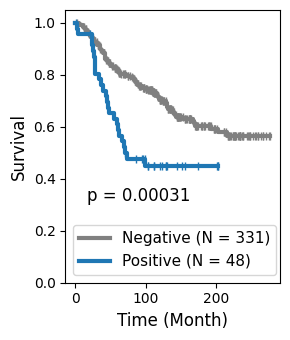

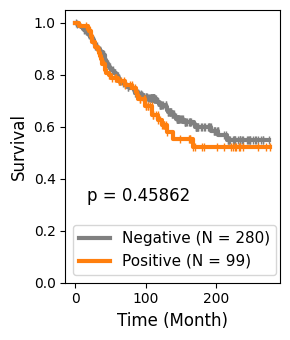

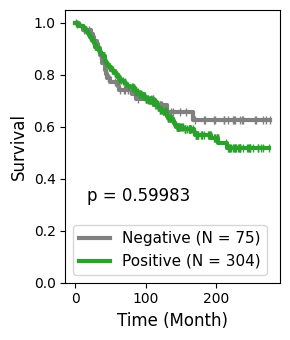

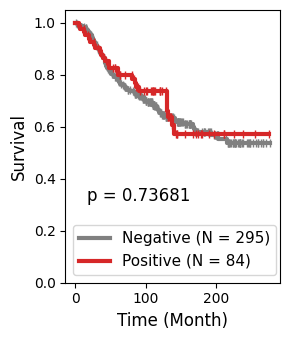

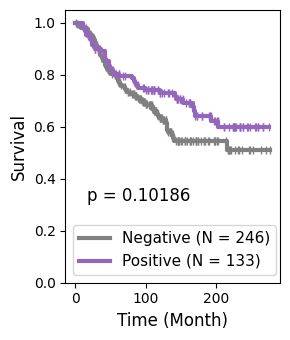

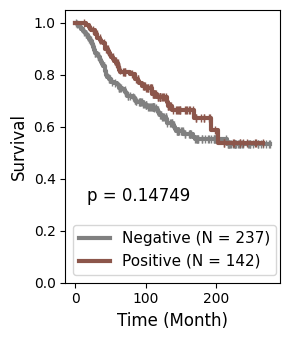

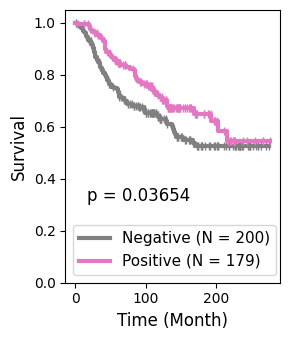

In [77]:
threshold = 0.01
for i in range(len(patient_subgroups_discovery)):
    subgroup_id = patient_subgroups_discovery[i]["subgroup_id"]
    characteristic_patterns = patient_subgroups_discovery[i]["characteristic_patterns"]
    f, ax = plt.subplots(figsize=(3, 3.5), tight_layout=True)
    proportion = Proportions[:, np.array(characteristic_patterns)].sum(axis=1) 
    kmf = KaplanMeierFitter()
    kmf.fit(
        np.array(lengths_discovery)[proportion < threshold],
        np.array(statuses_discovery)[proportion < threshold],
        label="Negative (N = {})".format(np.sum(proportion < threshold)),
    )
    kmf.plot_survival_function(
        ax=ax,
        ci_show=False,
        show_censors=True,
        censor_styles={"ms": 6, "marker": "|"},
        color="grey",
        linewidth=3,
    )
    kmf.fit(
        np.array(lengths_discovery)[(proportion >= threshold)],
        np.array(statuses_discovery)[(proportion >= threshold)],
        label="Positive (N = {})".format(np.sum((proportion >= threshold))),
    )
    kmf.plot_survival_function(
        ax=ax,
        ci_show=False,
        show_censors=True,
        censor_styles={"ms": 6, "marker": "|"},
        color=color_palette_Bigraph[subgroup_id],
        linewidth=3,
    )
    test = logrank_test(
        np.array(lengths_discovery)[proportion <= threshold],
        np.array(lengths_discovery)[(proportion > threshold)],
        np.array(statuses_discovery)[proportion <= threshold],
        np.array(statuses_discovery)[(proportion > threshold)],
    )
    ax.text(
        0.1, 0.3, "p = {:.5f}".format(test.p_value), fontsize=12, transform=ax.transAxes
    )
    ax.set(ylim=[0, 1.05], xlabel="Time (Month)", ylabel="Survival")
    ax.set_xlabel("Time (Month)", fontsize=12)
    ax.set_ylabel("Survival", fontsize=12)
    ax.legend(fontsize=11)
    plt.show()

## Fig.12 Correlation between TME patterns and tumor grade.

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1 vs. 2: Mann-Whitney-Wilcoxon test two-sided, P_val:2.305e-01 U_stat=2.358e+03
2 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:4.605e-05 U_stat=1.110e+04
1 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:2.047e-03 U_stat=2.421e+03
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1 vs. 2: Mann-Whitney-Wilcoxon test two-sided, P_val:2.362e-01 U_stat=2.904e+03
2 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:4.135e-06 U_stat=1.800e+04
1 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:3.397e-05 U_stat=4.765e+03


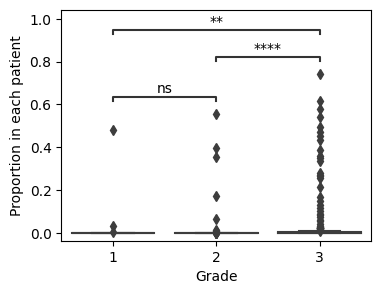

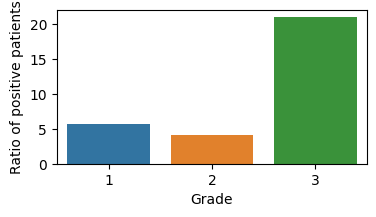

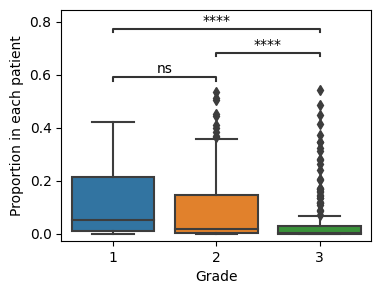

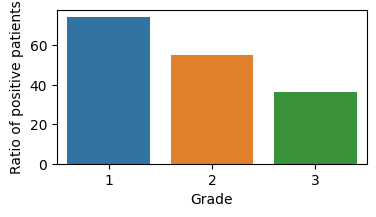

In [78]:
Histograms = bigraph_.fitted_soft_wl_subtree.Histograms
Proportions = Histograms/np.sum(Histograms, axis=1, keepdims=True)
patient_ids_discovery = list(SC_d["patientID"].unique())

from itertools import combinations
feature_name = 'Grade'
feature_list = [1,2,3]
compare_list = [(1,2), (2,3), (1,3)]

for i in range(len(patient_subgroups_discovery)):
    subgroup_id = patient_subgroups_discovery[i]["subgroup_id"]
    characteristic_patterns = patient_subgroups_discovery[i]["characteristic_patterns"]
    if subgroup_id not in ['S1', 'S7']:
        continue
    proportion = np.sum(Proportions[:, np.array(characteristic_patterns)], axis = 1)
    DF_presentation = pd.DataFrame(
        {
            "Proportion": proportion,
            feature_name:[survival_d.loc[survival_d["patientID"] == patient_id, feature_name].values[0]
                        for patient_id in patient_ids_discovery]

        }
    )
    DF_presentation = DF_presentation.dropna()
    f, ax = plt.subplots(figsize=(4,3))
    sns.boxplot(
        x=feature_name,
        y="Proportion",
        data=DF_presentation,
        showfliers=True,
        order = feature_list,
        # order=["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC"],
    )
    from statannotations.Annotator import Annotator

    annot = Annotator(
        ax,
        compare_list,
        data=DF_presentation,
        x=feature_name,
        y="Proportion",
        order = feature_list,
    )
    annot.configure(test="Mann-Whitney", text_format="star", loc="inside", verbose=2, )
    annot.apply_test()
    ax, test_results = annot.annotate()
    
    #ax.set(title = 'Proportion of pattern {} in each grade'.format(pattern_id[0]+1))
    ax.set(ylabel = 'Proportion in each patient')

    DF_existence = pd.DataFrame(
        {
            feature_name: feature_list,
        }
    )
    for feature in feature_list:
        data = DF_presentation.loc[
            DF_presentation[feature_name] == feature, "Proportion"
        ].values

        exisitence_ratio = np.sum(data > 0.01) / len(data)
        DF_existence.loc[
            DF_existence[feature_name] == feature, "Existence (%)"
        ] = (exisitence_ratio * 100)

    f, ax = plt.subplots(figsize=(4,2))
    sns.barplot(
        x=feature_name,
        y="Existence (%)",
        data=DF_existence,
        order=feature_list,
    )
    ax.set(ylabel = 'Ratio of positive patients')

## Fig. 13 Validation of the risk stratification results.

### Fig.13.I Validation on inner-validation set

In [79]:
patient_ids_iv = list(SC_iv["patientID"].unique())
subgroup_ids_iv = np.zeros(len(patient_ids_iv), dtype=object)
subgroup_ids_iv[:] = "Unclassified"
for i in range(len( patient_subgroups_iv)):
    subgroup = patient_subgroups_iv[i]
    subgroup_id = subgroup["subgroup_id"]
    patient_ids = subgroup["patient_ids"]
    subgroup_ids_iv[np.isin(patient_ids_iv, patient_ids)] = subgroup_id

#### Fig.13.I.a Population Graph

[[Text(-0.8, 0, ''),
  Text(-0.6000000000000001, 0, ''),
  Text(-0.4, 0, ''),
  Text(-0.19999999999999996, 0, ''),
  Text(0.0, 0, ''),
  Text(0.19999999999999996, 0, ''),
  Text(0.40000000000000013, 0, ''),
  Text(0.6000000000000001, 0, '')],
 [Text(-1.0, 0, ''),
  Text(-0.75, 0, ''),
  Text(-0.5, 0, ''),
  Text(-0.25, 0, ''),
  Text(0.0, 0, ''),
  Text(0.25, 0, ''),
  Text(0.5, 0, ''),
  Text(0.75, 0, ''),
  Text(1.0, 0, '')],
 [Text(-0.8, 0, ''),
  Text(-0.6000000000000001, 0, ''),
  Text(-0.4, 0, ''),
  Text(-0.19999999999999996, 0, ''),
  Text(0.0, 0, ''),
  Text(0.19999999999999996, 0, ''),
  Text(0.40000000000000013, 0, ''),
  Text(0.6000000000000001, 0, ''),
  Text(0.8, 0, ''),
  Text(1.0, 0, '')]]

/cis/home/zwang/venv/cell-gnn/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/cis/home/zwang/venv/cell-gnn/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  func(*args, **kwargs)


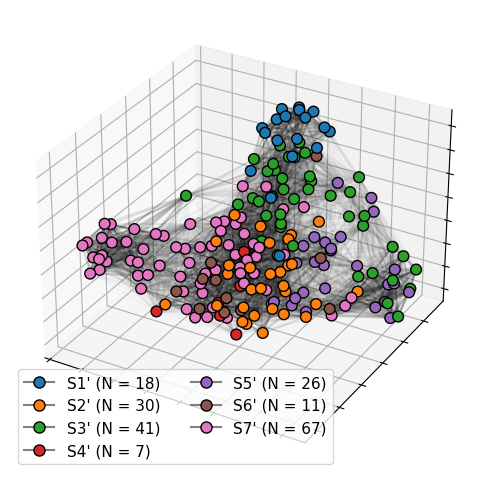

In [80]:
pos = nx.spring_layout(
    population_graph_iv,
    seed=100,
    k=1 / (np.sqrt(397)) * 10,
    iterations=100,
    dim=3,
)
fig = plt.figure(figsize=(5, 5), tight_layout=True)
ax = fig.add_subplot(111, projection="3d")
node_xyz = np.array([pos[v] for v in sorted(population_graph_iv)])
edge_xyz = np.array([(pos[u], pos[v]) for u, v in population_graph_iv.edges()])
ax.scatter(
    *node_xyz.T,
    s=60,
    c=[color_palette_Bigraph[i[:-1]] for i in subgroup_ids_iv],
    edgecolors="black",
    linewidths=1,
    alpha=1
)
edge_list = list(population_graph_iv.edges())
edge_alpha = [
    (
        0.2 * population_graph_iv[u][v]["weight"]
        if population_graph_iv[u][v]["weight"] > 0.1
        else 0
    )
    for u, v in edge_list
]
for i in range(len(edge_list)):
    u, v = edge_list[i]
    ax.plot(*edge_xyz[i].T, alpha=edge_alpha[i], color="k")

ax.set(
    xlim=(np.min(node_xyz[:, 0]), np.max(node_xyz[:, 0])),
    ylim=(np.min(node_xyz[:, 1]), np.max(node_xyz[:, 1])),
    zlim=(np.min(node_xyz[:, 2]), np.max(node_xyz[:, 2])),
)
handles = []
if np.sum(subgroup_ids_iv == "Unclassified") > 0:
    handles.append(
        Line2D(
            [0],
            [0],
            marker="o",
            color="white",
            markerfacecolor="white",
            label="Unclassified (N = {})".format(
                np.sum(subgroup_ids_iv == "Unclassified")
            ),
            markeredgecolor="black",
            markeredgewidth=1,
            markersize=8,
        )
    )
for subgroup in patient_subgroups_iv:
    subgroup_id = subgroup["subgroup_id"]
    handles.append(
        Line2D(
            [0],
            [0],
            marker="o",
            color="grey",
            markerfacecolor=color_palette_Bigraph[subgroup_id[:-1]],
            label="{} (N = {})".format(
                subgroup_id, np.sum(subgroup_ids_iv == subgroup_id)
            ),
            markeredgecolor="black",
            markeredgewidth=1,
            markersize=8,
        )
    )

ax.legend(handles=handles, fontsize=11, ncols=2)
ax.set(yticklabels=[], xticklabels=[], zticklabels=[])


#### Fig.13.I.b Survival plots

Patient subgroup S1': N = 18, HR = 1.64 (0.74-3.60), p = 2.20e-01
Patient subgroup S2': N = 30, HR = 0.83 (0.39-1.74), p = 6.16e-01
Patient subgroup S3': N = 41, HR = 1.66 (0.96-2.86), p = 6.83e-02
Patient subgroup S4': N = 7, HR = 0.38 (0.05-2.75), p = 3.38e-01
Patient subgroup S5': N = 26, HR = 1.02 (0.51-2.07), p = 9.47e-01
Patient subgroup S6': N = 11, HR = 0.93 (0.29-2.98), p = 9.08e-01
Patient subgroup S7': N = 67, HR = 0.68 (0.40-1.18), p = 1.70e-01


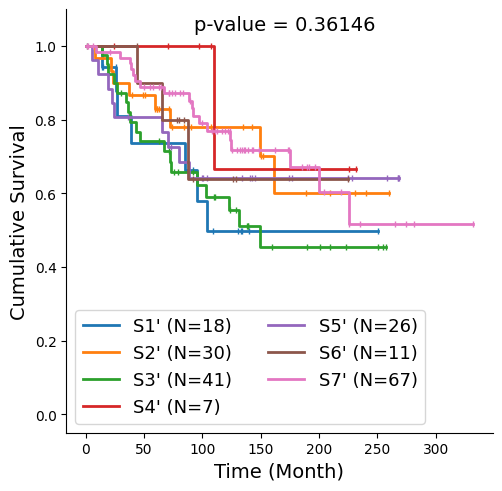

In [81]:
for i in range(len(patient_subgroups_iv)):
    print(
        "Patient subgroup {}: N = {}, HR = {:.2f} ({:.2f}-{:.2f}), p = {:.2e}".format(
            patient_subgroups_iv[i]['subgroup_id'],
            len(patient_subgroups_iv[i]["patient_ids"]),
            patient_subgroups_iv[i]["hr"],
            patient_subgroups_iv[i]["hr_lower"],
            patient_subgroups_iv[i]["hr_upper"],
            patient_subgroups_iv[i]["p"],
        )
    )

lengths_iv = [
            survival_iv.loc[survival_iv["patientID"] == i, "time"].values[0]
            for i in patient_ids_iv
        ]
statuses_iv = [
            survival_iv.loc[survival_iv["patientID"] == i, "status"].values[0]
            for i in patient_ids_iv
        ]
kmf = KaplanMeierFitter()
f, ax = plt.subplots(figsize=(5.5,5.5))
for subgroup in patient_subgroups_iv:
    subgroup_id = subgroup["subgroup_id"]
    length_A, event_observed_A = (
        np.array(lengths_iv)[subgroup_ids_iv == subgroup_id],
        np.array(statuses_iv)[subgroup_ids_iv == subgroup_id],
    )
    label = "{} (N={})".format(
        subgroup["subgroup_id"], np.sum(subgroup_ids_iv == subgroup_id)
    )
    kmf.fit(length_A, event_observed_A, label=label)
    kmf.plot_survival_function(
        ax=ax,
        ci_show=False,
        color=color_palette_Bigraph[subgroup_id[:-1]],
        show_censors=True,
        linewidth=2,
        censor_styles={"ms": 5, "marker": "|"},
    )
log_rank_test = multivariate_logrank_test(
    np.array(lengths_iv)[subgroup_ids_iv != 0],
    np.array(subgroup_ids_iv)[subgroup_ids_iv != 0],
    np.array(statuses_iv)[subgroup_ids_iv != 0],
)
p_value = log_rank_test.p_value
ax.legend(ncol=2, fontsize=13)
ax.text(
    x=0.3,
    y=0.95,
    s="p-value = {:.5f}".format(p_value),
    fontsize=14,
    transform=ax.transAxes,
)
ax.set_xlabel("Time (Month)", fontsize=14)
ax.set_ylabel("Cumulative Survival", fontsize=14)
ax.set(
    ylim=(-0.05, 1.1),
)
sns.despine()

#### Fig.13.I.c Hazard ratios

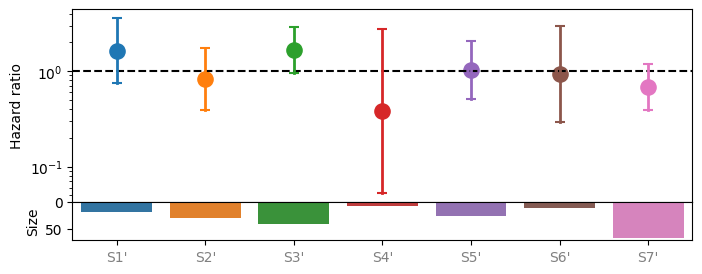

In [82]:
# Plot hazard ratio
f, ax = plt.subplots(2, 1, height_ratios=[5, 1], figsize=(8, 3), sharex=True)
f.subplots_adjust(hspace=0)
ax[0].hlines(1, -1, len(patient_subgroups_iv), color="k", linestyle="--")
N, xticklabels, xtickcolors = [], [], []
for i in range(len(patient_subgroups_iv)):
    subgroup = patient_subgroups_iv[i]
    subgroup_id = subgroup['subgroup_id']
    hr, hr_lb, hr_ub, p = (
            subgroup["hr"],
            subgroup["hr_lower"],
            subgroup["hr_upper"],
            subgroup["p"],
        )
    ax[0].plot([i, i], [hr_lb, hr_ub], color=color_palette_Bigraph[subgroup_id[:-1]], linewidth=2)
    ax[0].scatter([i], [hr], color=color_palette_Bigraph[subgroup_id[:-1]], s=120)
    ax[0].scatter([i], [hr_lb], color=color_palette_Bigraph[subgroup_id[:-1]], s=60, marker="_")
    ax[0].scatter([i], [hr_ub], color=color_palette_Bigraph[subgroup_id[:-1]], s=60, marker="_")
    N.append(np.sum(subgroup_ids_iv == subgroup_id))
    xticklabels.append("{}".format(subgroup_id))
    if p < 0.05:
        xtickcolors.append("k")
    else:
        xtickcolors.append("grey")
ax[0].set_xticks(range(len(patient_subgroups_iv)))
ax[0].set_xticklabels(xticklabels)
for xtick, color in zip(ax[1].get_xticklabels(), xtickcolors):
    xtick.set_color(color)
ax[0].set_xlabel("Patient Subgroups")
ax[0].set_ylabel("Hazard ratio")
ax[0].set_yscale("log")
DF = pd.DataFrame({"N": N, "subgroup_id": xticklabels})
g = sns.barplot(data=DF, x="subgroup_id", y="N", palette={key+"'": value for key, value in color_palette_Bigraph.items()}, ax=ax[1])
g.invert_yaxis()
ax[1].set_ylabel("Size")
ax[1].set_xlabel("")
plt.show()

### Fig.13.E Validation on external-validation set

In [83]:
patient_ids_ev = list(SC_ev["patientID"].unique())
subgroup_ids_ev = np.zeros(len(patient_ids_ev), dtype=object)
subgroup_ids_ev[:] = "Unclassified"
for i in range(len( patient_subgroups_ev)):
    subgroup = patient_subgroups_ev[i]
    subgroup_id = subgroup["subgroup_id"]
    patient_ids = subgroup["patient_ids"]
    subgroup_ids_ev[np.isin(patient_ids_ev, patient_ids)] = subgroup_id

#### Fig.13.E.a Population Graph

[[Text(-0.8, 0, ''),
  Text(-0.6000000000000001, 0, ''),
  Text(-0.4, 0, ''),
  Text(-0.19999999999999996, 0, ''),
  Text(0.0, 0, ''),
  Text(0.19999999999999996, 0, ''),
  Text(0.40000000000000013, 0, ''),
  Text(0.6000000000000001, 0, ''),
  Text(0.8, 0, ''),
  Text(1.0, 0, '')],
 [Text(-1.0, 0, ''),
  Text(-0.75, 0, ''),
  Text(-0.5, 0, ''),
  Text(-0.25, 0, ''),
  Text(0.0, 0, ''),
  Text(0.25, 0, ''),
  Text(0.5, 0, ''),
  Text(0.75, 0, ''),
  Text(1.0, 0, '')],
 [Text(-1.0, 0, ''),
  Text(-0.75, 0, ''),
  Text(-0.5, 0, ''),
  Text(-0.25, 0, ''),
  Text(0.0, 0, ''),
  Text(0.25, 0, ''),
  Text(0.5, 0, ''),
  Text(0.75, 0, ''),
  Text(1.0, 0, '')]]

/cis/home/zwang/venv/cell-gnn/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  func(*args, **kwargs)


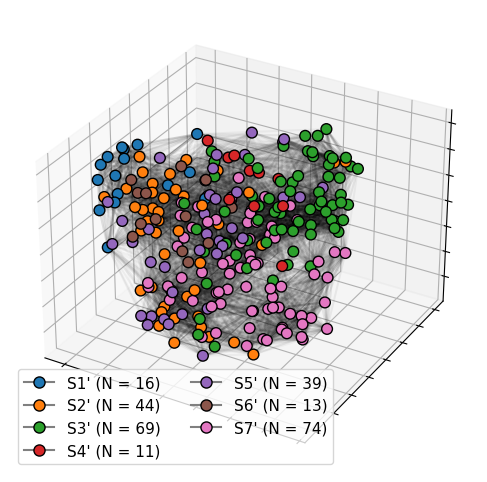

In [84]:
pos = nx.spring_layout(
    population_graph_ev,
    seed=1,
    k=1 / (np.sqrt(397)) * 10,
    iterations=100,
    dim=3,
)
fig = plt.figure(figsize=(5, 5), tight_layout=True)
ax = fig.add_subplot(111, projection="3d")
node_xyz = np.array([pos[v] for v in sorted(population_graph_ev)])
edge_xyz = np.array([(pos[u], pos[v]) for u, v in population_graph_ev.edges()])
ax.scatter(
    *node_xyz.T,
    s=60,
    c=[color_palette_Bigraph[i[:-1]] for i in subgroup_ids_ev],
    edgecolors="black",
    linewidths=1,
    alpha=1
)
edge_list = list(population_graph_ev.edges())
edge_alpha = [
    (
        0.2 * population_graph_ev[u][v]["weight"]
        if population_graph_ev[u][v]["weight"] > 0.1
        else 0
    )
    for u, v in edge_list
]
for i in range(len(edge_list)):
    u, v = edge_list[i]
    ax.plot(*edge_xyz[i].T, alpha=edge_alpha[i], color="k")

ax.set(
    xlim=(np.min(node_xyz[:, 0]), np.max(node_xyz[:, 0])),
    ylim=(np.min(node_xyz[:, 1]), np.max(node_xyz[:, 1])),
    zlim=(np.min(node_xyz[:, 2]), np.max(node_xyz[:, 2])),
)
handles = []
if np.sum(subgroup_ids_ev == "Unclassified") > 0:
    handles.append(
        Line2D(
            [0],
            [0],
            marker="o",
            color="white",
            markerfacecolor="white",
            label="Unclassified (N = {})".format(
                np.sum(subgroup_ids_ev == "Unclassified")
            ),
            markeredgecolor="black",
            markeredgewidth=1,
            markersize=8,
        )
    )
for subgroup in patient_subgroups_ev:
    subgroup_id = subgroup["subgroup_id"]
    handles.append(
        Line2D(
            [0],
            [0],
            marker="o",
            color="grey",
            markerfacecolor=color_palette_Bigraph[subgroup_id[:-1]],
            label="{} (N = {})".format(
                subgroup_id, np.sum(subgroup_ids_ev == subgroup_id)
            ),
            markeredgecolor="black",
            markeredgewidth=1,
            markersize=8,
        )
    )

ax.legend(handles=handles, fontsize=11, ncols=2, loc = 'lower left')
ax.set(yticklabels=[], xticklabels=[], zticklabels=[])


#### Fig.13.E.b Survival Plots

Patient subgroup S1': N = 16, HR = 3.03 (1.59-5.75), p = 7.24e-04
Patient subgroup S2': N = 44, HR = 1.56 (0.92-2.65), p = 1.00e-01
Patient subgroup S3': N = 69, HR = 0.67 (0.37-1.22), p = 1.89e-01
Patient subgroup S4': N = 11, HR = 0.81 (0.26-2.59), p = 7.28e-01
Patient subgroup S5': N = 39, HR = 0.89 (0.46-1.74), p = 7.38e-01
Patient subgroup S6': N = 13, HR = 1.18 (0.43-3.23), p = 7.49e-01
Patient subgroup S7': N = 74, HR = 0.65 (0.38-1.11), p = 1.19e-01


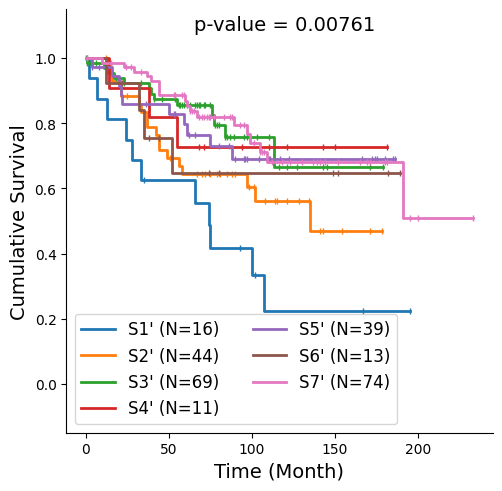

In [85]:
for i in range(len(patient_subgroups_ev)):
    print(
        "Patient subgroup {}: N = {}, HR = {:.2f} ({:.2f}-{:.2f}), p = {:.2e}".format(
            patient_subgroups_ev[i]['subgroup_id'],
            len(patient_subgroups_ev[i]["patient_ids"]),
            patient_subgroups_ev[i]["hr"],
            patient_subgroups_ev[i]["hr_lower"],
            patient_subgroups_ev[i]["hr_upper"],
            patient_subgroups_ev[i]["p"],
        )
    )

lengths_ev = [
            survival_ev.loc[survival_ev["patientID"] == i, "time"].values[0]
            for i in patient_ids_ev
        ]
statuses_ev = [
            survival_ev.loc[survival_ev["patientID"] == i, "status"].values[0]
            for i in patient_ids_ev
        ]
kmf = KaplanMeierFitter()
f, ax = plt.subplots(figsize=(5.5,5.5))
for subgroup in patient_subgroups_ev:
    subgroup_id = subgroup["subgroup_id"]
    length_A, event_observed_A = (
        np.array(lengths_ev)[subgroup_ids_ev == subgroup_id],
        np.array(statuses_ev)[subgroup_ids_ev == subgroup_id],
    )
    label = "{} (N={})".format(
        subgroup["subgroup_id"], np.sum(subgroup_ids_ev == subgroup_id)
    )
    kmf.fit(length_A, event_observed_A, label=label)
    kmf.plot_survival_function(
        ax=ax,
        ci_show=False,
        color=color_palette_Bigraph[subgroup_id[:-1]],
        show_censors=True,
        linewidth=2,
        censor_styles={"ms": 5, "marker": "|"},
    )
log_rank_test = multivariate_logrank_test(
    np.array(lengths_ev)[subgroup_ids_ev != 0],
    np.array(subgroup_ids_ev)[subgroup_ids_ev != 0],
    np.array(statuses_ev)[subgroup_ids_ev != 0],
)
p_value = log_rank_test.p_value
ax.legend(ncol=2, fontsize=12, loc = 'lower left')
ax.text(
    x=0.3,
    y=0.95,
    s="p-value = {:.5f}".format(p_value),
    fontsize=14,
    transform=ax.transAxes,
)
ax.set_xlabel("Time (Month)", fontsize=14)
ax.set_ylabel("Cumulative Survival", fontsize=14)
ax.set(
    ylim=(-0.15, 1.15),
)
sns.despine()

#### Fig.13.E.c Hazard ratios

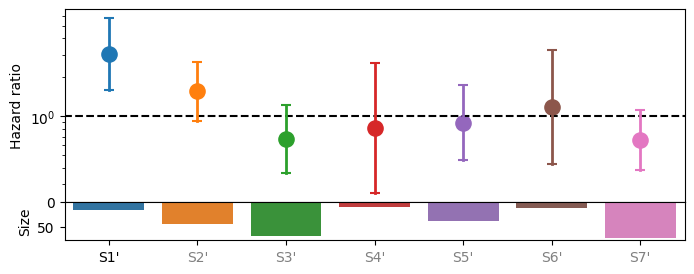

In [86]:
# Plot hazard ratio
f, ax = plt.subplots(2, 1, height_ratios=[5, 1], figsize=(8, 3), sharex=True)
f.subplots_adjust(hspace=0)
ax[0].hlines(1, -1, len(patient_subgroups_ev), color="k", linestyle="--")
N, xticklabels, xtickcolors = [], [], []
for i in range(len(patient_subgroups_ev)):
    subgroup = patient_subgroups_ev[i]
    subgroup_id = subgroup['subgroup_id']
    hr, hr_lb, hr_ub, p = (
            subgroup["hr"],
            subgroup["hr_lower"],
            subgroup["hr_upper"],
            subgroup["p"],
        )
    ax[0].plot([i, i], [hr_lb, hr_ub], color=color_palette_Bigraph[subgroup_id[:-1]], linewidth=2)
    ax[0].scatter([i], [hr], color=color_palette_Bigraph[subgroup_id[:-1]], s=120)
    ax[0].scatter([i], [hr_lb], color=color_palette_Bigraph[subgroup_id[:-1]], s=60, marker="_")
    ax[0].scatter([i], [hr_ub], color=color_palette_Bigraph[subgroup_id[:-1]], s=60, marker="_")
    N.append(np.sum(subgroup_ids_ev == subgroup_id))
    xticklabels.append("{}".format(subgroup_id))
    if p < 0.05:
        xtickcolors.append("k")
    else:
        xtickcolors.append("grey")
ax[0].set_xticks(range(len(patient_subgroups_ev)))
ax[0].set_xticklabels(xticklabels)
for xtick, color in zip(ax[1].get_xticklabels(), xtickcolors):
    xtick.set_color(color)
ax[0].set_xlabel("Patient Subgroups")
ax[0].set_ylabel("Hazard ratio")
ax[0].set_yscale("log")
DF = pd.DataFrame({"N": N, "subgroup_id": xticklabels})
g = sns.barplot(data=DF, x="subgroup_id", y="N", palette={key+"'": value for key, value in color_palette_Bigraph.items()}, ax=ax[1])
g.invert_yaxis()
ax[1].set_ylabel("Size")
ax[1].set_xlabel("")
plt.show()

## Fig. 14 Validation of the enhancement of risk stratification 

### Fig.14.I Inner-validation set

In [87]:
patient_ids_iv = list(SC_iv["patientID"].unique())
subgroup_ids_iv = np.zeros(len(patient_ids_iv), dtype=object)
subgroup_ids_iv[:] = "Unclassified"
for i in range(len( patient_subgroups_iv)):
    subgroup = patient_subgroups_iv[i]
    subgroup_id = subgroup["subgroup_id"]
    patient_ids = subgroup["patient_ids"]
    subgroup_ids_iv[np.isin(patient_ids_iv, patient_ids)] = subgroup_id

lengths_iv = [
            survival_iv.loc[survival_iv["patientID"] == i, "time"].values[0]
            for i in patient_ids_iv
        ]
statuses_iv = [
            survival_iv.loc[survival_iv["patientID"] == i, "status"].values[0]
            for i in patient_ids_iv
        ]

clinical_subtypes_iv = np.zeros(len(patient_ids_iv), dtype=object)
clinical_subtypes_iv[:] = 'Unknown'
for i in range(len(patient_ids_iv)):
    patient_id = patient_ids_iv[i]
    er = survival_iv.loc[survival_iv['patientID'] == patient_id, 'ER Status'].values[0]
    pr = survival_iv.loc[survival_iv['patientID'] == patient_id, 'PR Status'].values[0]
    her2 = survival_iv.loc[survival_iv['patientID'] == patient_id, 'HER2 Status'].values[0]
    if  her2 == "Positive":
        clinical_subtypes_iv[i] = 'HER2+' # Her2+
    if (er == "Positive" or pr == "Positive") and her2 == "Negative":
        clinical_subtypes_iv[i] = 'HR+/HER2-' # HR+/HER2-
    elif (er == "Negative" and pr == "Negative") and her2 == "Negative":
        clinical_subtypes_iv[i] = 'TNBC' # TNBC
print(
    "{} patients in total, {} Unkonw, {} HER2+, {} HR+/HER2-, {} TNBC".format(
        len(clinical_subtypes_iv),
              np.sum(clinical_subtypes_iv == 'Unknown'),
        np.sum(clinical_subtypes_iv == 'HER2+'),
        np.sum(clinical_subtypes_iv == 'HR+/HER2-'),
        np.sum(clinical_subtypes_iv == 'TNBC'),
  

    )
)

200 patients in total, 24 Unkonw, 29 HER2+, 116 HR+/HER2-, 31 TNBC


#### Fig.14.I.a HER2+ and S1'

     test_statistic         p  -log2(p)
1 2        9.365519  0.002211  8.821050
  3        0.417797  0.518038  0.948869
2 3        2.039883  0.153221  2.706310


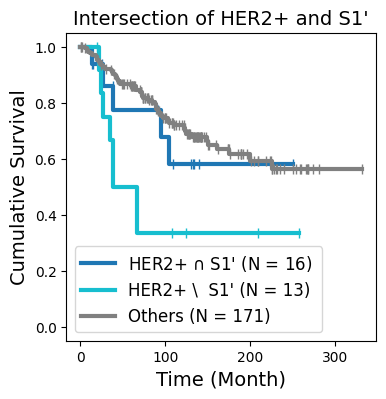

In [88]:
clinical_subtype = "HER2+"
subgroup_id = "S1'"
lengths_iv = np.array(lengths_iv)
statuses_iv = np.array(statuses_iv)
f, ax = plt.subplots(figsize=(4,4))
kmf = KaplanMeierFitter()
Indices_A = (subgroup_ids_iv == subgroup_id) & (clinical_subtypes_iv == clinical_subtype)
length_A, event_observed_A = (
    lengths_iv[Indices_A],
    statuses_iv[Indices_A],
)
label = r"{} $\cap$ {} (N = {}) ".format(clinical_subtype, subgroup_id, len(length_A))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(
    ax=ax,
    ci_show=False,
    color=color_palette_Bigraph[subgroup_id[:-1]],
    show_censors=True,
    censor_styles={"ms": 7, "marker": "|"},
    markerfacecolor="grey",
    linewidth=3,
    label=label,
)

Indices_C = (subgroup_ids_iv != subgroup_id) & (clinical_subtypes_iv == clinical_subtype)
length_C, event_observed_C = (
    lengths_iv[Indices_C],
    statuses_iv[Indices_C],
)
label = r"{} \  {} (N = {}) ".format(clinical_subtype, subgroup_id, len(length_C))
kmf.fit(length_C, event_observed_C, label=label)
kmf.plot_survival_function(
    ax=ax,
    ci_show=False,
    color=color_palette_clinical[clinical_subtype],
    show_censors=True,
    censor_styles={"ms": 7, "marker": "|"},
    markerfacecolor="grey",

    linewidth=3,
)

Indices_B = (
    (clinical_subtypes_iv != clinical_subtype)
)
length_B, event_observed_B = (
    lengths_iv[Indices_B],
    statuses_iv[Indices_B],
)
label = r"Others (N = {})".format(len(length_B))
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(
    ax=ax,
    ci_show=False,
    color="grey",
    show_censors=True,
    censor_styles={"ms": 7, "marker": "|"},
    linewidth=3,
    label=label,  
)


groups = np.zeros_like(clinical_subtypes_iv, dtype=int)
groups[:] = 1
groups[((clinical_subtypes_iv == clinical_subtype)) & (subgroup_ids_iv != subgroup_id)] = 2
groups[((clinical_subtypes_iv == clinical_subtype)) & (subgroup_ids_iv == subgroup_id)] = 3


log_rank_test = pairwise_logrank_test(
    lengths_iv,
    groups,
    statuses_iv,
)
print(log_rank_test.summary)


ax.legend(fontsize=12)
ax.set_xlabel("Time (Month)", fontsize=14)
ax.set_ylabel("Cumulative Survival", fontsize=14)
ax.set(
    ylim=(-0.05, 1.05),
)
ax.set_title("Intersection of {} and {}".format(clinical_subtype, subgroup_id), fontsize=14)
plt.show()

#### Fig.14.I.b TNBC and S2'

     test_statistic         p  -log2(p)
1 2        1.156851  0.282120  1.825621
  3        0.028358  0.866270  0.207112
2 3        0.619989  0.431052  1.214068


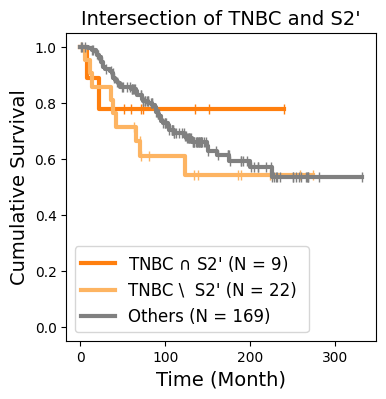

In [89]:
clinical_subtype = "TNBC"
subgroup_id = "S2'"
lengths_iv = np.array(lengths_iv)
statuses_iv = np.array(statuses_iv)
f, ax = plt.subplots(figsize=(4,4))
kmf = KaplanMeierFitter()
Indices_A = (subgroup_ids_iv == subgroup_id) & (clinical_subtypes_iv == clinical_subtype)
length_A, event_observed_A = (
    lengths_iv[Indices_A],
    statuses_iv[Indices_A],
)
label = r"{} $\cap$ {} (N = {}) ".format(clinical_subtype, subgroup_id, len(length_A))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(
    ax=ax,
    ci_show=False,
    color=color_palette_Bigraph[subgroup_id[:-1]],
    show_censors=True,
    censor_styles={"ms": 7, "marker": "|"},
    markerfacecolor="grey",
    linewidth=3,
    label=label,
)

Indices_C = (subgroup_ids_iv != subgroup_id) & (clinical_subtypes_iv == clinical_subtype)
length_C, event_observed_C = (
    lengths_iv[Indices_C],
    statuses_iv[Indices_C],
)
label = r"{} \  {} (N = {}) ".format(clinical_subtype, subgroup_id, len(length_C))
kmf.fit(length_C, event_observed_C, label=label)
kmf.plot_survival_function(
    ax=ax,
    ci_show=False,
    color=color_palette_clinical[clinical_subtype],
    show_censors=True,
    censor_styles={"ms": 7, "marker": "|"},
    markerfacecolor="grey",

    linewidth=3,
)

Indices_B = (
    (clinical_subtypes_iv != clinical_subtype)
)
length_B, event_observed_B = (
    lengths_iv[Indices_B],
    statuses_iv[Indices_B],
)
label = r"Others (N = {})".format(len(length_B))
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(
    ax=ax,
    ci_show=False,
    color="grey",
    show_censors=True,
    censor_styles={"ms": 7, "marker": "|"},
    linewidth=3,
    label=label,  
)


groups = np.zeros_like(clinical_subtypes_iv, dtype=int)
groups[:] = 1
groups[((clinical_subtypes_iv == clinical_subtype)) & (subgroup_ids_iv != subgroup_id)] = 2
groups[((clinical_subtypes_iv == clinical_subtype)) & (subgroup_ids_iv == subgroup_id)] = 3


log_rank_test = pairwise_logrank_test(
    lengths_iv,
    groups,
    statuses_iv,
)
print(log_rank_test.summary)


ax.legend(fontsize=12)
ax.set_xlabel("Time (Month)", fontsize=14)
ax.set_ylabel("Cumulative Survival", fontsize=14)
ax.set(
    ylim=(-0.05, 1.05),
)
ax.set_title("Intersection of {} and {}".format(clinical_subtype, subgroup_id), fontsize=14)
plt.show()

#### Fig.14.I.a HR+/HER2- and S7'

     test_statistic         p  -log2(p)
1 2        8.209400  0.004167  7.906639
  3        7.153855  0.007480  7.062687
2 3        0.120046  0.728984  0.456040


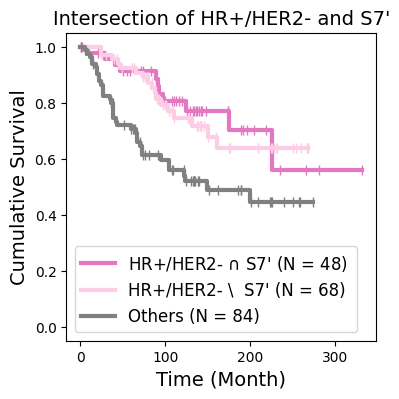

In [90]:
clinical_subtype = "HR+/HER2-"
subgroup_id = "S7'"
lengths_iv = np.array(lengths_iv)
statuses_iv = np.array(statuses_iv)
f, ax = plt.subplots(figsize=(4,4))
kmf = KaplanMeierFitter()
Indices_A = (subgroup_ids_iv == subgroup_id) & (clinical_subtypes_iv == clinical_subtype)
length_A, event_observed_A = (
    lengths_iv[Indices_A],
    statuses_iv[Indices_A],
)
label = r"{} $\cap$ {} (N = {}) ".format(clinical_subtype, subgroup_id, len(length_A))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(
    ax=ax,
    ci_show=False,
    color=color_palette_Bigraph[subgroup_id[:-1]],
    show_censors=True,
    censor_styles={"ms": 7, "marker": "|"},
    markerfacecolor="grey",
    linewidth=3,
    label=label,
)

Indices_C = (subgroup_ids_iv != subgroup_id) & (clinical_subtypes_iv == clinical_subtype)
length_C, event_observed_C = (
    lengths_iv[Indices_C],
    statuses_iv[Indices_C],
)
label = r"{} \  {} (N = {}) ".format(clinical_subtype, subgroup_id, len(length_C))
kmf.fit(length_C, event_observed_C, label=label)
kmf.plot_survival_function(
    ax=ax,
    ci_show=False,
    color=color_palette_clinical[clinical_subtype],
    show_censors=True,
    censor_styles={"ms": 7, "marker": "|"},
    markerfacecolor="grey",

    linewidth=3,
)

Indices_B = (
    (clinical_subtypes_iv != clinical_subtype)
)
length_B, event_observed_B = (
    lengths_iv[Indices_B],
    statuses_iv[Indices_B],
)
label = r"Others (N = {})".format(len(length_B))
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(
    ax=ax,
    ci_show=False,
    color="grey",
    show_censors=True,
    censor_styles={"ms": 7, "marker": "|"},
    linewidth=3,
    label=label,  
)


groups = np.zeros_like(clinical_subtypes_iv, dtype=int)
groups[:] = 1
groups[((clinical_subtypes_iv == clinical_subtype)) & (subgroup_ids_iv != subgroup_id)] = 2
groups[((clinical_subtypes_iv == clinical_subtype)) & (subgroup_ids_iv == subgroup_id)] = 3


log_rank_test = pairwise_logrank_test(
    lengths_iv,
    groups,
    statuses_iv,
)
print(log_rank_test.summary)


ax.legend(fontsize=12)
ax.set_xlabel("Time (Month)", fontsize=14)
ax.set_ylabel("Cumulative Survival", fontsize=14)
ax.set(
    ylim=(-0.05, 1.05),
)
ax.set_title("Intersection of {} and {}".format(clinical_subtype, subgroup_id), fontsize=14)
plt.show()

### Fig.14.E External-validation set

In [91]:
patient_ids_ev = list(SC_ev["patientID"].unique())
subgroup_ids_ev = np.zeros(len(patient_ids_ev), dtype=object)
subgroup_ids_ev[:] = "Unclassified"
for i in range(len( patient_subgroups_ev)):
    subgroup = patient_subgroups_ev[i]
    subgroup_id = subgroup["subgroup_id"]
    patient_ids = subgroup["patient_ids"]
    subgroup_ids_ev[np.isin(patient_ids_ev, patient_ids)] = subgroup_id

lengths_ev = [
            survival_ev.loc[survival_ev["patientID"] == i, "time"].values[0]
            for i in patient_ids_ev
        ]
statuses_ev = [
            survival_ev.loc[survival_ev["patientID"] == i, "status"].values[0]
            for i in patient_ids_ev
        ]

clinical_subtypes_ev = np.zeros(len(patient_ids_ev), dtype=object)
clinical_subtypes_ev[:] = 'Unknown'
for i in range(len(patient_ids_ev)):
    patient_id = patient_ids_ev[i]
    er = survival_ev.loc[survival_ev['patientID'] == patient_id, 'ERStatus'].values[0]
    pr = survival_ev.loc[survival_ev['patientID'] == patient_id, 'PRStatus'].values[0]
    her2 = survival_ev.loc[survival_ev['patientID'] == patient_id, 'HER2Status'].values[0]
    if  her2 == "positive":
        clinical_subtypes_ev[i] = 'HER2+' # Her2+
    if (er == "positive" or pr == "positive") and her2 == "negative":
        clinical_subtypes_ev[i] = 'HR+/HER2-' # HR+/HER2-
    elif (er == "negative" and pr == "negative") and her2 == "negative":
        clinical_subtypes_ev[i] = 'TNBC' # TNBC
print(
    "{} patients in total, {} Unkonw, {} HER2+, {} HR+/HER2-, {} TNBC".format(
        len(clinical_subtypes_iv),
              np.sum(clinical_subtypes_ev == 'Unknown'),
        np.sum(clinical_subtypes_ev == 'HER2+'),
        np.sum(clinical_subtypes_ev == 'HR+/HER2-'),
        np.sum(clinical_subtypes_ev == 'TNBC'),
  

    )
)

200 patients in total, 1 Unkonw, 47 HER2+, 173 HR+/HER2-, 45 TNBC


#### Fig.14.E.a HER2+ and S1'

     test_statistic         p  -log2(p)
1 2        0.097256  0.755147  0.405170
  3        2.583070  0.108012  3.210737
2 3        1.905317  0.167484  2.577901


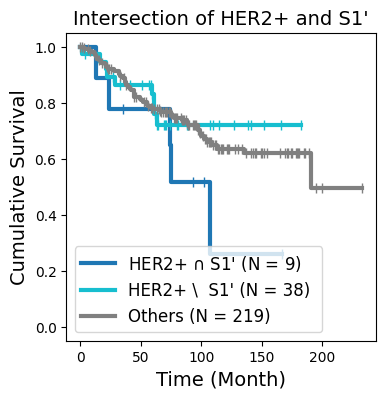

In [92]:
clinical_subtype = "HER2+"
subgroup_id = "S1'"
lengths_ev = np.array(lengths_ev)
statuses_ev = np.array(statuses_ev)
f, ax = plt.subplots(figsize=(4,4))
kmf = KaplanMeierFitter()
Indices_A = (subgroup_ids_ev == subgroup_id) & (clinical_subtypes_ev == clinical_subtype)
length_A, event_observed_A = (
    lengths_ev[Indices_A],
    statuses_ev[Indices_A],
)
label = r"{} $\cap$ {} (N = {}) ".format(clinical_subtype, subgroup_id, len(length_A))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(
    ax=ax,
    ci_show=False,
    color=color_palette_Bigraph[subgroup_id[:-1]],
    show_censors=True,
    censor_styles={"ms": 7, "marker": "|"},
    markerfacecolor="grey",
    linewidth=3,
    label=label,
)

Indices_C = (subgroup_ids_ev != subgroup_id) & (clinical_subtypes_ev == clinical_subtype)
length_C, event_observed_C = (
    lengths_ev[Indices_C],
    statuses_ev[Indices_C],
)
label = r"{} \  {} (N = {}) ".format(clinical_subtype, subgroup_id, len(length_C))
kmf.fit(length_C, event_observed_C, label=label)
kmf.plot_survival_function(
    ax=ax,
    ci_show=False,
    color=color_palette_clinical[clinical_subtype],
    show_censors=True,
    censor_styles={"ms": 7, "marker": "|"},
    markerfacecolor="grey",

    linewidth=3,
)

Indices_B = (
    (clinical_subtypes_ev != clinical_subtype)
)
length_B, event_observed_B = (
    lengths_ev[Indices_B],
    statuses_ev[Indices_B],
)
label = r"Others (N = {})".format(len(length_B))
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(
    ax=ax,
    ci_show=False,
    color="grey",
    show_censors=True,
    censor_styles={"ms": 7, "marker": "|"},
    linewidth=3,
    label=label,  
)


groups = np.zeros_like(clinical_subtypes_ev, dtype=int)
groups[:] = 1
groups[((clinical_subtypes_ev == clinical_subtype)) & (subgroup_ids_ev != subgroup_id)] = 2
groups[((clinical_subtypes_ev == clinical_subtype)) & (subgroup_ids_ev == subgroup_id)] = 3


log_rank_test = pairwise_logrank_test(
    lengths_ev,
    groups,
    statuses_ev,
)
print(log_rank_test.summary)


ax.legend(fontsize=12)
ax.set_xlabel("Time (Month)", fontsize=14)
ax.set_ylabel("Cumulative Survival", fontsize=14)
ax.set(
    ylim=(-0.05, 1.05),
)
ax.set_title("Intersection of {} and {}".format(clinical_subtype, subgroup_id), fontsize=14)
plt.show()

#### Fig.14.E.b TNBC and S2'

     test_statistic         p   -log2(p)
1 2        4.830528  0.027960   5.160488
  3       11.360074  0.000750  10.380056
2 3        1.549866  0.213155   2.230024


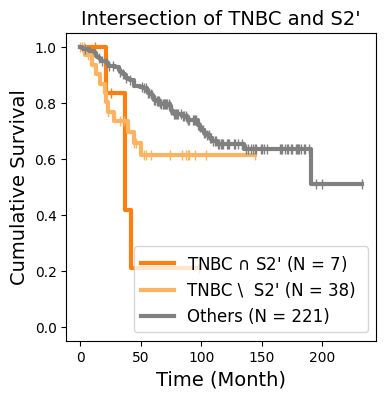

In [93]:
clinical_subtype = "TNBC"
subgroup_id = "S2'"
lengths_ev = np.array(lengths_ev)
statuses_ev = np.array(statuses_ev)
f, ax = plt.subplots(figsize=(4,4))
kmf = KaplanMeierFitter()
Indices_A = (subgroup_ids_ev == subgroup_id) & (clinical_subtypes_ev == clinical_subtype)
length_A, event_observed_A = (
    lengths_ev[Indices_A],
    statuses_ev[Indices_A],
)
label = r"{} $\cap$ {} (N = {}) ".format(clinical_subtype, subgroup_id, len(length_A))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(
    ax=ax,
    ci_show=False,
    color=color_palette_Bigraph[subgroup_id[:-1]],
    show_censors=True,
    censor_styles={"ms": 7, "marker": "|"},
    markerfacecolor="grey",
    linewidth=3,
    label=label,
)

Indices_C = (subgroup_ids_ev != subgroup_id) & (clinical_subtypes_ev == clinical_subtype)
length_C, event_observed_C = (
    lengths_ev[Indices_C],
    statuses_ev[Indices_C],
)
label = r"{} \  {} (N = {}) ".format(clinical_subtype, subgroup_id, len(length_C))
kmf.fit(length_C, event_observed_C, label=label)
kmf.plot_survival_function(
    ax=ax,
    ci_show=False,
    color=color_palette_clinical[clinical_subtype],
    show_censors=True,
    censor_styles={"ms": 7, "marker": "|"},
    markerfacecolor="grey",

    linewidth=3,
)

Indices_B = (
    (clinical_subtypes_ev != clinical_subtype)
)
length_B, event_observed_B = (
    lengths_ev[Indices_B],
    statuses_ev[Indices_B],
)
label = r"Others (N = {})".format(len(length_B))
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(
    ax=ax,
    ci_show=False,
    color="grey",
    show_censors=True,
    censor_styles={"ms": 7, "marker": "|"},
    linewidth=3,
    label=label,  
)


groups = np.zeros_like(clinical_subtypes_ev, dtype=int)
groups[:] = 1
groups[((clinical_subtypes_ev == clinical_subtype)) & (subgroup_ids_ev != subgroup_id)] = 2
groups[((clinical_subtypes_ev == clinical_subtype)) & (subgroup_ids_ev == subgroup_id)] = 3


log_rank_test = pairwise_logrank_test(
    lengths_ev,
    groups,
    statuses_ev,
)
print(log_rank_test.summary)


ax.legend(fontsize=12)
ax.set_xlabel("Time (Month)", fontsize=14)
ax.set_ylabel("Cumulative Survival", fontsize=14)
ax.set(
    ylim=(-0.05, 1.05),
)
ax.set_title("Intersection of {} and {}".format(clinical_subtype, subgroup_id), fontsize=14)
plt.show()

#### Fig.14.E.c HR+/HER2- and S7'

     test_statistic         p  -log2(p)
1 2        2.189188  0.138983  2.847025
  3        6.288181  0.012155  6.362357
2 3        1.714386  0.190417  2.392764


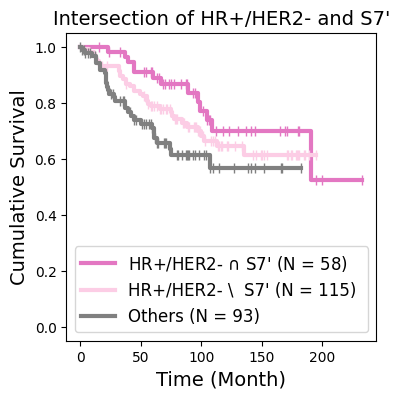

In [94]:
clinical_subtype = "HR+/HER2-"
subgroup_id = "S7'"
lengths_ev = np.array(lengths_ev)
statuses_ev = np.array(statuses_ev)
f, ax = plt.subplots(figsize=(4,4))
kmf = KaplanMeierFitter()
Indices_A = (subgroup_ids_ev == subgroup_id) & (clinical_subtypes_ev == clinical_subtype)
length_A, event_observed_A = (
    lengths_ev[Indices_A],
    statuses_ev[Indices_A],
)
label = r"{} $\cap$ {} (N = {}) ".format(clinical_subtype, subgroup_id, len(length_A))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(
    ax=ax,
    ci_show=False,
    color=color_palette_Bigraph[subgroup_id[:-1]],
    show_censors=True,
    censor_styles={"ms": 7, "marker": "|"},
    markerfacecolor="grey",
    linewidth=3,
    label=label,
)

Indices_C = (subgroup_ids_ev != subgroup_id) & (clinical_subtypes_ev == clinical_subtype)
length_C, event_observed_C = (
    lengths_ev[Indices_C],
    statuses_ev[Indices_C],
)
label = r"{} \  {} (N = {}) ".format(clinical_subtype, subgroup_id, len(length_C))
kmf.fit(length_C, event_observed_C, label=label)
kmf.plot_survival_function(
    ax=ax,
    ci_show=False,
    color=color_palette_clinical[clinical_subtype],
    show_censors=True,
    censor_styles={"ms": 7, "marker": "|"},
    markerfacecolor="grey",

    linewidth=3,
)

Indices_B = (
    (clinical_subtypes_ev != clinical_subtype)
)
length_B, event_observed_B = (
    lengths_ev[Indices_B],
    statuses_ev[Indices_B],
)
label = r"Others (N = {})".format(len(length_B))
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(
    ax=ax,
    ci_show=False,
    color="grey",
    show_censors=True,
    censor_styles={"ms": 7, "marker": "|"},
    linewidth=3,
    label=label,  
)


groups = np.zeros_like(clinical_subtypes_ev, dtype=int)
groups[:] = 1
groups[((clinical_subtypes_ev == clinical_subtype)) & (subgroup_ids_ev != subgroup_id)] = 2
groups[((clinical_subtypes_ev == clinical_subtype)) & (subgroup_ids_ev == subgroup_id)] = 3


log_rank_test = pairwise_logrank_test(
    lengths_ev,
    groups,
    statuses_ev,
)
print(log_rank_test.summary)


ax.legend(fontsize=12)
ax.set_xlabel("Time (Month)", fontsize=14)
ax.set_ylabel("Cumulative Survival", fontsize=14)
ax.set(
    ylim=(-0.05, 1.05),
)
ax.set_title("Intersection of {} and {}".format(clinical_subtype, subgroup_id), fontsize=14)
plt.show()

## Fig. 15 Validation of the prognostic impacts of TME patterns

### Fig.15.I Inner-validation set

In [95]:
patient_ids_iv = list(SC_iv["patientID"].unique())
proportions_iv = histograms_iv/np.sum(histograms_iv, axis=1, keepdims=True)
lengths_iv = [
            survival_iv.loc[survival_iv["patientID"] == i, "time"].values[0]
            for i in patient_ids_iv
        ]
statuses_iv = [
            survival_iv.loc[survival_iv["patientID"] == i, "status"].values[0]
            for i in patient_ids_iv
        ]

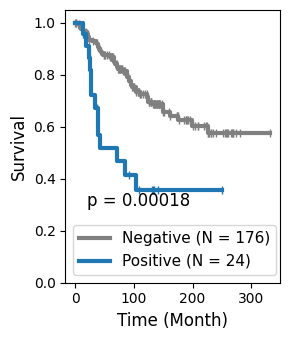

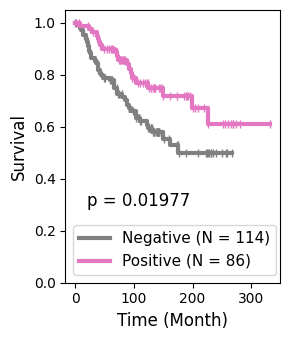

In [96]:
threshold = 0.01
for i in range(len(patient_subgroups_discovery)):
    subgroup_id = patient_subgroups_discovery[i]["subgroup_id"]
    if subgroup_id not in ["S1", "S7"]:
        continue
    characteristic_patterns = patient_subgroups_discovery[i]["characteristic_patterns"]
    f, ax = plt.subplots(figsize=(3, 3.5), tight_layout=True)
    proportion = proportions_iv[:, np.array(characteristic_patterns)].sum(axis=1) 
    kmf = KaplanMeierFitter()
    kmf.fit(
        np.array(lengths_iv)[proportion < threshold],
        np.array(statuses_iv)[proportion < threshold],
        label="Negative (N = {})".format(np.sum(proportion < threshold)),
    )
    kmf.plot_survival_function(
        ax=ax,
        ci_show=False,
        show_censors=True,
        censor_styles={"ms": 6, "marker": "|"},
        color="grey",
        linewidth=3,
    )
    kmf.fit(
        np.array(lengths_iv)[(proportion >= threshold)],
        np.array(statuses_iv)[(proportion >= threshold)],
        label="Positive (N = {})".format(np.sum((proportion >= threshold))),
    )
    kmf.plot_survival_function(
        ax=ax,
        ci_show=False,
        show_censors=True,
        censor_styles={"ms": 6, "marker": "|"},
        color=color_palette_Bigraph[subgroup_id],
        linewidth=3,
    )
    test = logrank_test(
        np.array(lengths_iv)[proportion <= threshold],
        np.array(lengths_iv)[(proportion > threshold)],
        np.array(statuses_iv)[proportion <= threshold],
        np.array(statuses_iv)[(proportion > threshold)],
    )
    ax.text(
        0.1, 0.28, "p = {:.5f}".format(test.p_value), fontsize=12, transform=ax.transAxes
    )
    ax.set(ylim=[0, 1.05], xlabel="Time (Month)", ylabel="Survival")
    ax.set_xlabel("Time (Month)", fontsize=12)
    ax.set_ylabel("Survival", fontsize=12)
    ax.legend(fontsize=11)
    plt.show()

### Fig.15.E  External-validation set

In [12]:
patient_ids_ev = list(SC_ev["patientID"].unique())
proportions_ev = histograms_ev/np.sum(histograms_ev, axis=1, keepdims=True)
lengths_ev = [
            survival_ev.loc[survival_ev["patientID"] == i, "time"].values[0]
            for i in patient_ids_ev
        ]
statuses_ev = [
            survival_ev.loc[survival_ev["patientID"] == i, "status"].values[0]
            for i in patient_ids_ev
        ]

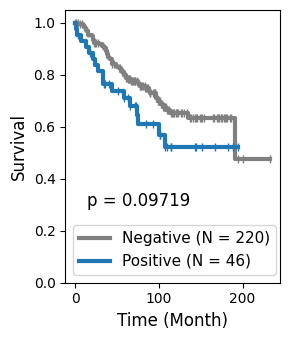

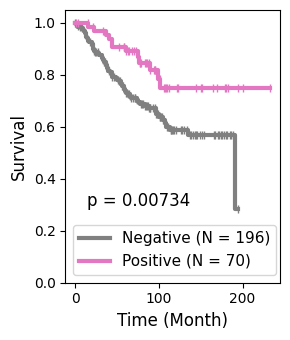

In [14]:
threshold = 0.01
for i in range(len(patient_subgroups_discovery)):
    subgroup_id = patient_subgroups_discovery[i]["subgroup_id"]
    if subgroup_id not in ["S1", "S7"]:
        continue
    characteristic_patterns = patient_subgroups_discovery[i]["characteristic_patterns"]
    f, ax = plt.subplots(figsize=(3, 3.5), tight_layout=True)
    proportion = proportions_ev[:, np.array(characteristic_patterns)].sum(axis=1) 
    kmf = KaplanMeierFitter()
    kmf.fit(
        np.array(lengths_ev)[proportion < threshold],
        np.array(statuses_ev)[proportion < threshold],
        label="Negative (N = {})".format(np.sum(proportion < threshold)),
    )
    kmf.plot_survival_function(
        ax=ax,
        ci_show=False,
        show_censors=True,
        censor_styles={"ms": 6, "marker": "|"},
        color="grey",
        linewidth=3,
    )
    kmf.fit(
        np.array(lengths_ev)[(proportion >= threshold)],
        np.array(statuses_ev)[(proportion >= threshold)],
        label="Positive (N = {})".format(np.sum((proportion >= threshold))),
    )
    kmf.plot_survival_function(
        ax=ax,
        ci_show=False,
        show_censors=True,
        censor_styles={"ms": 6, "marker": "|"},
        color=color_palette_Bigraph[subgroup_id],
        linewidth=3,
    )
    test = logrank_test(
        np.array(lengths_ev)[proportion <= threshold],
        np.array(lengths_ev)[(proportion > threshold)],
        np.array(statuses_ev)[proportion <= threshold],
        np.array(statuses_ev)[(proportion > threshold)],
    )
    ax.text(
        0.1, 0.28, "p = {:.5f}".format(test.p_value), fontsize=12, transform=ax.transAxes
    )
    ax.set(ylim=[0, 1.05], xlabel="Time (Month)", ylabel="Survival")
    ax.set_xlabel("Time (Month)", fontsize=12)
    ax.set_ylabel("Survival", fontsize=12)
    ax.legend(fontsize=11)
    plt.show()

## Fig.16 Validation of prognostic impact of characteristic patterns

### Fig.16.I Inner-validation Set

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1 vs. 2: Mann-Whitney-Wilcoxon test two-sided, P_val:3.623e-01 U_stat=4.320e+02
2 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:2.820e-04 U_stat=2.654e+03
1 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:1.375e-02 U_stat=6.960e+02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1 vs. 2: Mann-Whitney-Wilcoxon test two-sided, P_val:5.088e-01 U_stat=5.060e+02
2 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:3.823e-06 U_stat=4.956e+03
1 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:7.890e-04 U_stat=1.461e+03


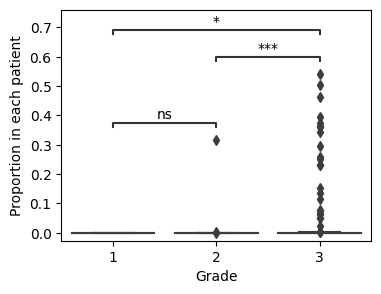

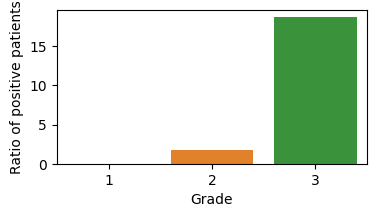

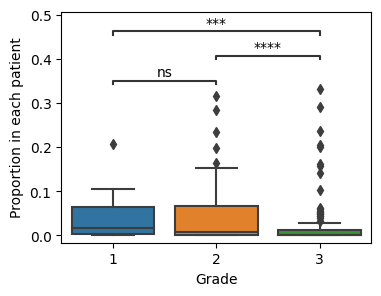

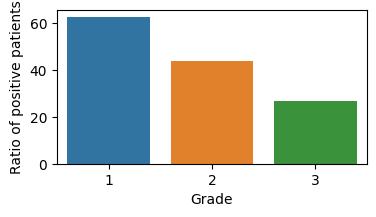

In [16]:
Histograms = histograms_iv
Proportions = Histograms/np.sum(Histograms, axis=1, keepdims=True)
patient_ids_iv = list(SC_iv["patientID"].unique())

from itertools import combinations
feature_name = 'Grade'
feature_list = [1,2,3]
compare_list = [(1,2), (2,3), (1,3)]

for i in range(len(patient_subgroups_discovery)):
    subgroup_id = patient_subgroups_discovery[i]["subgroup_id"]
    characteristic_patterns = patient_subgroups_discovery[i]["characteristic_patterns"]
    if subgroup_id not in ['S1', 'S7']:
        continue
    proportion = np.sum(Proportions[:, np.array(characteristic_patterns)], axis = 1)
    DF_presentation = pd.DataFrame(
        {
            "Proportion": proportion,
            feature_name:[survival_iv.loc[survival_iv["patientID"] == patient_id, feature_name].values[0]
                        for patient_id in patient_ids_iv]

        }
    )
    DF_presentation = DF_presentation.dropna()
    f, ax = plt.subplots(figsize=(4,3))
    sns.boxplot(
        x=feature_name,
        y="Proportion",
        data=DF_presentation,
        showfliers=True,
        order = feature_list,
        # order=["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC"],
    )
    from statannotations.Annotator import Annotator

    annot = Annotator(
        ax,
        compare_list,
        data=DF_presentation,
        x=feature_name,
        y="Proportion",
        order = feature_list,
    )
    annot.configure(test="Mann-Whitney", text_format="star", loc="inside", verbose=2, )
    annot.apply_test()
    ax, test_results = annot.annotate()
    
    #ax.set(title = 'Proportion of pattern {} in each grade'.format(pattern_id[0]+1))
    ax.set(ylabel = 'Proportion in each patient')

    DF_existence = pd.DataFrame(
        {
            feature_name: feature_list,
        }
    )
    for feature in feature_list:
        data = DF_presentation.loc[
            DF_presentation[feature_name] == feature, "Proportion"
        ].values

        exisitence_ratio = np.sum(data > 0.01) / len(data)
        DF_existence.loc[
            DF_existence[feature_name] == feature, "Existence (%)"
        ] = (exisitence_ratio * 100)

    f, ax = plt.subplots(figsize=(4,2))
    sns.barplot(
        x=feature_name,
        y="Existence (%)",
        data=DF_existence,
        order=feature_list,
    )
    ax.set(ylabel = 'Ratio of positive patients')

### Fig.16.E External-validation Set

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1 vs. 2: Mann-Whitney-Wilcoxon test two-sided, P_val:6.897e-01 U_stat=1.894e+03
2 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:7.596e-01 U_stat=6.813e+03
1 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:8.511e-01 U_stat=2.024e+03
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1 vs. 2: Mann-Whitney-Wilcoxon test two-sided, P_val:9.454e-01 U_stat=1.993e+03
2 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:6.933e-06 U_stat=8.864e+03
1 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:1.618e-03 U_stat=2.749e+03


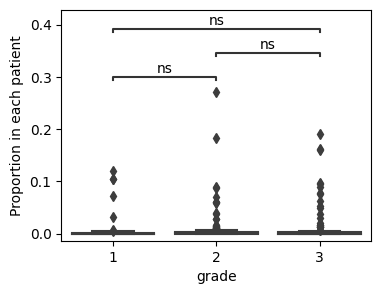

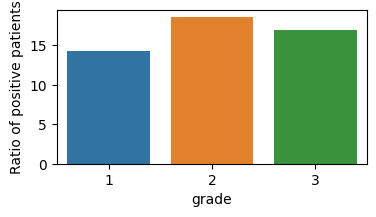

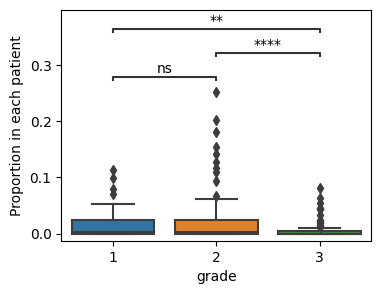

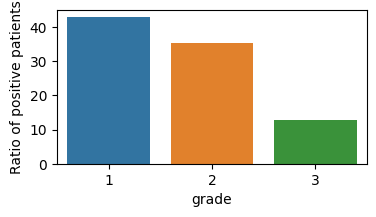

In [20]:
Histograms = histograms_ev
Proportions = Histograms/np.sum(Histograms, axis=1, keepdims=True)
patient_ids_ev = list(SC_ev["patientID"].unique())

from itertools import combinations
feature_name = 'grade'
feature_list = [1,2,3]
compare_list = [(1,2), (2,3), (1,3)]

for i in range(len(patient_subgroups_discovery)):
    subgroup_id = patient_subgroups_discovery[i]["subgroup_id"]
    characteristic_patterns = patient_subgroups_discovery[i]["characteristic_patterns"]
    if subgroup_id not in ['S1', 'S7']:
        continue
    proportion = np.sum(Proportions[:, np.array(characteristic_patterns)], axis = 1)
    DF_presentation = pd.DataFrame(
        {
            "Proportion": proportion,
            feature_name:[survival_ev.loc[survival_ev["patientID"] == patient_id, feature_name].values[0]
                        for patient_id in patient_ids_ev]

        }
    )
    DF_presentation = DF_presentation.dropna()
    f, ax = plt.subplots(figsize=(4,3))
    sns.boxplot(
        x=feature_name,
        y="Proportion",
        data=DF_presentation,
        showfliers=True,
        order = feature_list,
        # order=["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC"],
    )
    from statannotations.Annotator import Annotator

    annot = Annotator(
        ax,
        compare_list,
        data=DF_presentation,
        x=feature_name,
        y="Proportion",
        order = feature_list,
    )
    annot.configure(test="Mann-Whitney", text_format="star", loc="inside", verbose=2, )
    annot.apply_test()
    ax, test_results = annot.annotate()
    
    #ax.set(title = 'Proportion of pattern {} in each grade'.format(pattern_id[0]+1))
    ax.set(ylabel = 'Proportion in each patient')

    DF_existence = pd.DataFrame(
        {
            feature_name: feature_list,
        }
    )
    for feature in feature_list:
        data = DF_presentation.loc[
            DF_presentation[feature_name] == feature, "Proportion"
        ].values

        exisitence_ratio = np.sum(data > 0.01) / len(data)
        DF_existence.loc[
            DF_existence[feature_name] == feature, "Existence (%)"
        ] = (exisitence_ratio * 100)

    f, ax = plt.subplots(figsize=(4,2))
    sns.barplot(
        x=feature_name,
        y="Existence (%)",
        data=DF_existence,
        order=feature_list,
    )
    ax.set(ylabel = 'Ratio of positive patients')

## Appendix

### Fig.A.1.a Median protein profiling for Danenberg et al

In [ ]:
Cell_type_name_list = [
    reverse_dict(get_node_id("Danenberg", "CellType"))[i] for i in range(32)
]
SC_d_raw["meta_description"] = pd.Categorical(
    SC_d_raw["meta_description"], categories=Cell_type_name_list, ordered=True
)
expression_per_phenoptype = SC_d_raw.groupby("meta_description")[Protein_list_Danenberg].median()
expression_per_phenoptype_scaled = (
    expression_per_phenoptype - expression_per_phenoptype.mean()
) / expression_per_phenoptype.std()


f, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(
    expression_per_phenoptype_scaled,
    ax=ax,
    cmap="RdBu_r",
    center=0,
    vmin=-2,
    vmax=2,
    cbar=True,
    linewidth=0.1,
)
ax.set_xticklabels(
    Protein_list_display_Danenberg,
    fontsize=12,
)

ax.set_yticklabels(Cell_types_displayed_Danenberg, fontsize=12, fontweight="bold")
# ax.set_yticklabels(ax.get_yticklabels(), fontsize = 12, fontweight='bold')
ax.set_xlabel("Antigens", fontsize=18, fontweight="bold")
ax.set_ylabel("Cell Phenotypes", fontsize=18, fontweight="bold")
ytickcolors = ["cornflowerblue"] * 16 + ["darkorange"] * 11 + ["forestgreen"] * 5
for ytick, color in zip(ax.get_yticklabels(), ytickcolors):
    ytick.set_color(color)
ax.set_title(
    "z-scored median expression of antigens per cell phenotype",
    fontsize=20,
    fontweight="bold",
)
f.show()

### Fig A.1.b Median Protein profiling for Jackson et al

In [ ]:
SC_ev_raw["cell_type"] = pd.Categorical(
    SC_ev_raw["cell_type"], categories=Cell_types_displayed_Jackson, ordered=True
)
expression_per_phenoptype = SC_ev_raw.groupby("cell_type")[Protein_list_Jackson].median()
expression_per_phenoptype_scaled = (
    expression_per_phenoptype - expression_per_phenoptype.mean()
) / expression_per_phenoptype.std()


f, ax = plt.subplots(figsize=(15, 7))
sns.heatmap(
    expression_per_phenoptype_scaled,
    ax=ax,
    cmap="RdBu_r",
    center=0,
    vmin=-2,
    vmax=2,
    cbar=True,
    linewidth=0.1,
)
ax.set_xticklabels(Protein_list_display_Jackson, fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12, fontweight="bold")
ax.set_xlabel("Antigens", fontsize=18, fontweight="bold")
ax.set_ylabel("Cell Phenotypes", fontsize=18, fontweight="bold")
ax.set_title(
    "z-scored median expression of antigens per cell phenotype",
    fontsize=20,
    fontweight="bold",
)
ytickcolors = ["cornflowerblue"] * 13 + ["darkorange"] * 6 + ["forestgreen"] * 7
for ytick, color in zip(ax.get_yticklabels(), ytickcolors):
    ytick.set_color(color)
f.show()

### Fig.A.2 Distribution of TME pattern expression in each of the seven patient subgroups

In [34]:
Signatures = bigraph_.fitted_soft_wl_subtree.Signatures
# Define tumor niches, immune niches, stromal niches, and interfacing niches
threshold = 0.5  # does not impact the downstream analysis, only imapct the presentation of the signature map
tumor_niche = np.where(
    (np.sum(Signatures[:, :16] > threshold, axis=1) > 0)
    & (np.sum(Signatures[:, 16:] > threshold, axis=1) == 0)
)[0]
immune_niche = np.where(
    (np.sum(Signatures[:, :16] > threshold, axis=1) == 0)
    & (np.sum(Signatures[:, 16:27] > threshold, axis=1) > 0)
    & (np.sum(Signatures[:, 27:] > threshold, axis=1) == 0)
)[0]
stromal_niche = np.where(
    (np.sum(Signatures[:, :16] > threshold, axis=1) == 0)
    & (np.sum(Signatures[:, 16:27] > threshold, axis=1) == 0)
    & (np.sum(Signatures[:, 27:] > threshold, axis=1) > 0)
)[0]
interacting_niche = [
    i
    for i in range(Signatures.shape[0])
    if i not in np.concatenate([tumor_niche, immune_niche, stromal_niche])
]
print("There are {} identified TME patterns.".format(Signatures.shape[0]))
print(
    "There are {} tumor niches, {} immune niches, {} stromal niches, and {} interacting niches.".format(
        len(tumor_niche), len(immune_niche), len(stromal_niche), len(interacting_niche)
    )
)
tme_pattern_orders = np.concatenate([tumor_niche, immune_niche, stromal_niche, interacting_niche])

There are 66 identified TME patterns.
There are 37 tumor niches, 4 immune niches, 11 stromal niches, and 14 interacting niches.


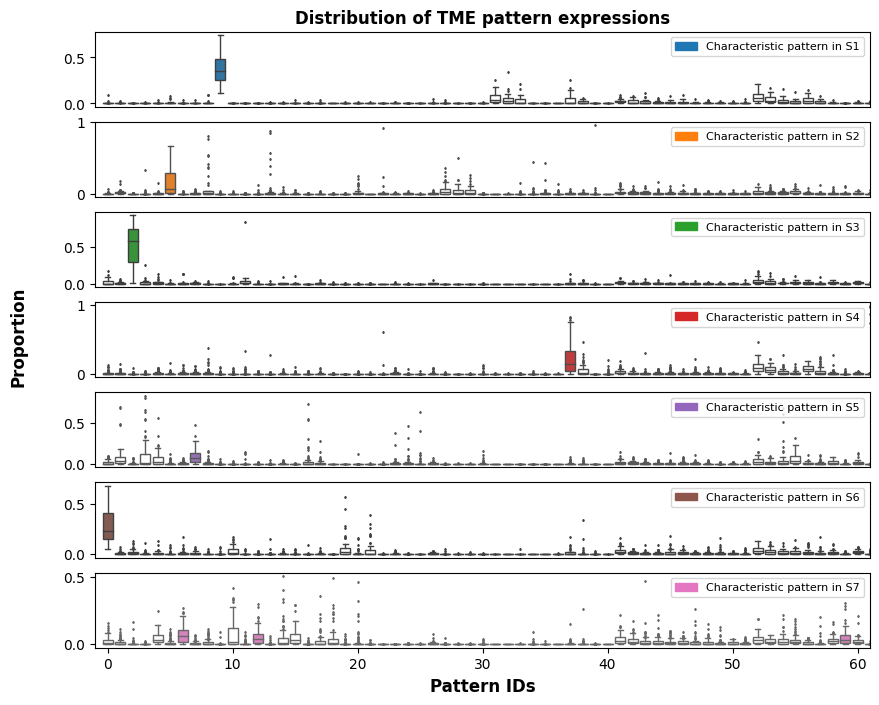

In [35]:
f, ax = plt.subplots(len(patient_subgroups_discovery), 1, figsize=(10,8), sharex=True)
for i in range(len(patient_subgroups_discovery)):
    subgroup_id = patient_subgroups_discovery[i]['subgroup_id']
    proportions_in_group = patient_subgroups_discovery[i]['proportions_in_group']
    hodges_lehmanns = patient_subgroups_discovery[i]['hodges_lehmanns']
    characteristic_patterns = patient_subgroups_discovery[i]['characteristic_patterns']
    DF_proportion = pd.DataFrame(proportions_in_group)
    DF_proportion = DF_proportion.melt(var_name = 'pattern_id', value_name = 'proportion')
    DF_proportion["characteristic"] = np.isin(DF_proportion['pattern_id'], characteristic_patterns)
    sns.boxplot(
        data=DF_proportion,
        x="pattern_id",
        y="proportion",
        ax=ax[i],
        hue="characteristic",
        showfliers=True,
        fliersize=1,
        palette={True: color_palette_Bigraph[subgroup_id], False: "white"},
        dodge =False,
        linewidth=1,
        order = tme_pattern_orders
    )
    handles = [
        patches.Rectangle(
            (0.4, 0.1),
            1,
            1,
            edgecolor=color_palette_Bigraph[subgroup_id],
            facecolor=color_palette_Bigraph[subgroup_id],
            label="Characteristic pattern in {}".format(subgroup_id),
        ),
    ]
    ax[i].legend(handles=handles, fontsize=8, loc = 'upper right')
    ax[i].set_ylabel("", fontsize=8)
    ax[i].get_xaxis().set_visible(False)
    ax[i].set(xlim = (-1, 61))
    
ax[0].set_title("Distribution of TME pattern expressions".format(subgroup_id), fontweight = 'bold')
ax[-1].get_xaxis().set_visible(True)
ax[-1].set(
    xticks = [0,10,20,30,40,50,60],
    xticklabels = [0,10,20,30,40,50,60],
)
ax[-1].set_xlabel("Pattern IDs", fontsize=12, fontweight = 'bold')
f.text(0.04, 0.5, 'Proportion', va='center', rotation='vertical', fontweight = 'bold', fontsize = 12)
plt.show()

### Fig.A.3 Hodge-lehmann statistics of TME pattern expressions in each of the seven patient subgroups

In [36]:
Signatures = bigraph_.fitted_soft_wl_subtree.Signatures
# Define tumor niches, immune niches, stromal niches, and interfacing niches
threshold = 0.5  # does not impact the downstream analysis, only imapct the presentation of the signature map
tumor_niche = np.where(
    (np.sum(Signatures[:, :16] > threshold, axis=1) > 0)
    & (np.sum(Signatures[:, 16:] > threshold, axis=1) == 0)
)[0]
immune_niche = np.where(
    (np.sum(Signatures[:, :16] > threshold, axis=1) == 0)
    & (np.sum(Signatures[:, 16:27] > threshold, axis=1) > 0)
    & (np.sum(Signatures[:, 27:] > threshold, axis=1) == 0)
)[0]
stromal_niche = np.where(
    (np.sum(Signatures[:, :16] > threshold, axis=1) == 0)
    & (np.sum(Signatures[:, 16:27] > threshold, axis=1) == 0)
    & (np.sum(Signatures[:, 27:] > threshold, axis=1) > 0)
)[0]
interacting_niche = [
    i
    for i in range(Signatures.shape[0])
    if i not in np.concatenate([tumor_niche, immune_niche, stromal_niche])
]
print("There are {} identified TME patterns.".format(Signatures.shape[0]))
print(
    "There are {} tumor niches, {} immune niches, {} stromal niches, and {} interacting niches.".format(
        len(tumor_niche), len(immune_niche), len(stromal_niche), len(interacting_niche)
    )
)
tme_pattern_orders = np.concatenate([tumor_niche, immune_niche, stromal_niche, interacting_niche])

There are 66 identified TME patterns.
There are 37 tumor niches, 4 immune niches, 11 stromal niches, and 14 interacting niches.


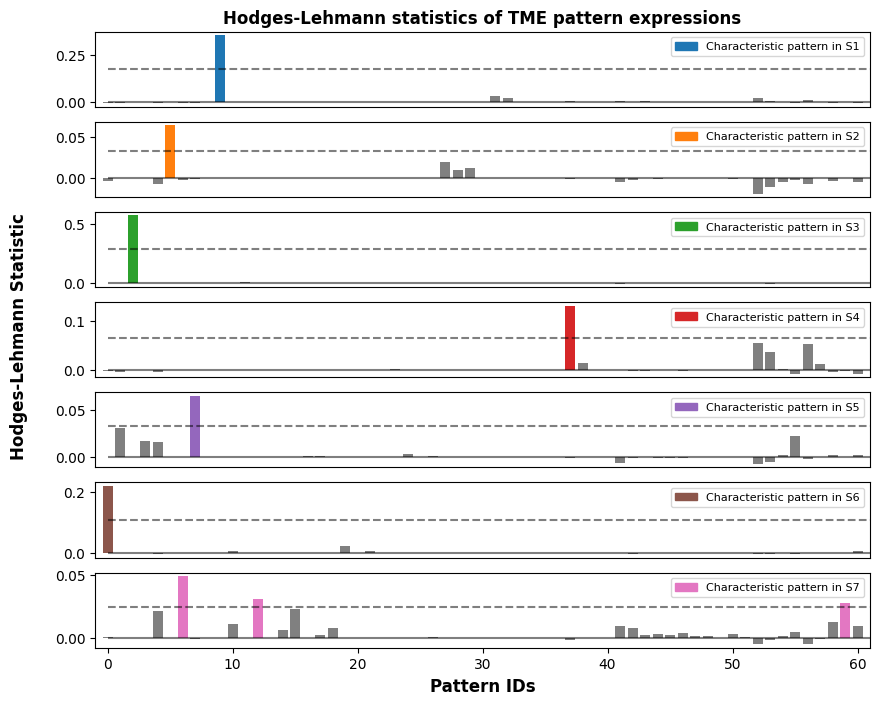

In [37]:
f, ax = plt.subplots(
    len(patient_subgroups_discovery),
    1,
    figsize=(10,8),
    sharex=True,
)
for i in range(len(patient_subgroups_discovery)):
    subgroup_id = patient_subgroups_discovery[i]["subgroup_id"]
    hodges_lehmanns = patient_subgroups_discovery[i]["hodges_lehmanns"]
    characteristic_patterns = patient_subgroups_discovery[i]["characteristic_patterns"]
    ax[i].bar(
        np.arange(len(hodges_lehmanns)),
        np.array(hodges_lehmanns)[tme_pattern_orders],
        color=[
            (
                color_palette_Bigraph[subgroup_id]
                if i in characteristic_patterns
                else "grey"
            )
            for i in tme_pattern_orders
        ],
    )
    handles = [
        patches.Rectangle(
            (0.6, 0.2),
            1,
            1,
            edgecolor=color_palette_Bigraph[subgroup_id],
            facecolor=color_palette_Bigraph[subgroup_id],
            label="Characteristic pattern in {}".format(subgroup_id),
        ),
    ]
    ax[i].legend(handles=handles, fontsize=8, loc="upper right")
    ax[i].set_ylabel("", fontsize=8)
    ax[i].get_xaxis().set_visible(False)
    ax[i].set(xlim=(-1, 61))
    ax[i].hlines(
        0.5 * np.max(hodges_lehmanns), 0, len(hodges_lehmanns), color="k", linestyle="--", alpha = 0.5
    )
    ax[i].hlines(0, 0, len(hodges_lehmanns), color="k", alpha = 0.5)
    

ax[0].set_title("Hodges-Lehmann statistics of TME pattern expressions", fontweight="bold")
ax[-1].get_xaxis().set_visible(True)
ax[-1].set_xlabel("Pattern IDs", fontsize=10, fontweight = 'bold')
ax[-1].set(
    xticks=[0, 10, 20, 30, 40, 50, 60],
    xticklabels=[0, 10, 20, 30, 40, 50, 60],
)
ax[-1].set_xlabel("Pattern IDs", fontsize=12)
f.text(0.04, 0.5, 'Hodges-Lehmann Statistic', va='center', rotation='vertical', fontweight = 'bold', fontsize = 12)
plt.show()

### Fig.A.4 Correlation between TME patterns and tumor stage.

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1 vs. 2: Mann-Whitney-Wilcoxon test two-sided, P_val:3.023e-01 U_stat=8.227e+03
3 vs. 4: Mann-Whitney-Wilcoxon test two-sided, P_val:9.198e-01 U_stat=5.200e+01
2 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:3.364e-01 U_stat=2.328e+03
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1 vs. 2: Mann-Whitney-Wilcoxon test two-sided, P_val:4.740e-01 U_stat=8.284e+03
3 vs. 4: Mann-Whitney-Wilcoxon test two-sided, P_val:4.907e-01 U_stat=6.600e+01
2 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:8.314e-01 U_stat=2.630e+03


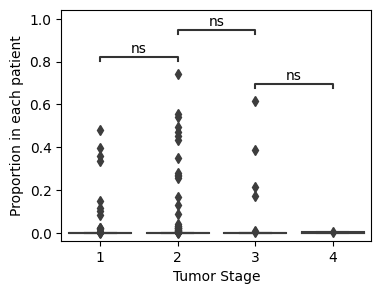

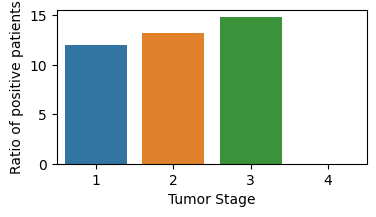

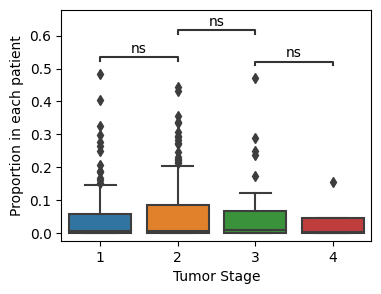

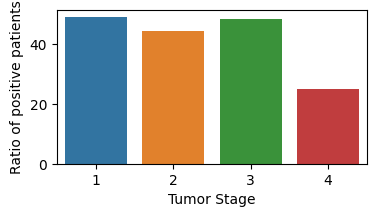

In [38]:
Histograms = bigraph_.fitted_soft_wl_subtree.Histograms
Proportions = Histograms/np.sum(Histograms, axis=1, keepdims=True)
patient_ids_discovery = list(SC_d["patientID"].unique())

from itertools import combinations
feature_name = 'Tumor Stage'
feature_list = [1,2,3, 4]
compare_list = [ (1,2), (3,4) ,(2,3),]

for i in range(len(patient_subgroups_discovery)):
    subgroup_id = patient_subgroups_discovery[i]["subgroup_id"]
    characteristic_patterns = patient_subgroups_discovery[i]["characteristic_patterns"]
    if subgroup_id not in ['S1', 'S7']:
        continue
    proportion = np.sum(Proportions[:, np.array(characteristic_patterns)], axis = 1)
    DF_presentation = pd.DataFrame(
        {
            "Proportion": proportion,
            feature_name:[survival_d.loc[survival_d["patientID"] == patient_id, feature_name].values[0]
                        for patient_id in patient_ids_discovery]

        }
    )
    DF_presentation = DF_presentation.dropna()
    f, ax = plt.subplots(figsize=(4,3))
    sns.boxplot(
        x=feature_name,
        y="Proportion",
        data=DF_presentation,
        showfliers=True,
        order = feature_list,
        # order=["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC"],
    )
    from statannotations.Annotator import Annotator

    annot = Annotator(
        ax,
        compare_list,
        data=DF_presentation,
        x=feature_name,
        y="Proportion",
        order = feature_list,
    )
    annot.configure(test="Mann-Whitney", text_format="star", loc="inside", verbose=2, )
    annot.apply_test()
    ax, test_results = annot.annotate()
    
    #ax.set(title = 'Proportion of pattern {} in each grade'.format(pattern_id[0]+1))
    ax.set(ylabel = 'Proportion in each patient')

    DF_existence = pd.DataFrame(
        {
            feature_name: feature_list,
        }
    )
    for feature in feature_list:
        data = DF_presentation.loc[
            DF_presentation[feature_name] == feature, "Proportion"
        ].values

        exisitence_ratio = np.sum(data > 0.01) / len(data)
        DF_existence.loc[
            DF_existence[feature_name] == feature, "Existence (%)"
        ] = (exisitence_ratio * 100)

    f, ax = plt.subplots(figsize=(4,2))
    sns.barplot(
        x=feature_name,
        y="Existence (%)",
        data=DF_existence,
        order=feature_list,
    )
    ax.set(ylabel = 'Ratio of positive patients')

### Fig.A.5 Correlation between TME patterns and Metastasis

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Yes vs. No: Mann-Whitney-Wilcoxon test two-sided, P_val:9.329e-02 U_stat=1.922e+04
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Yes vs. No: Mann-Whitney-Wilcoxon test two-sided, P_val:5.171e-02 U_stat=1.990e+04


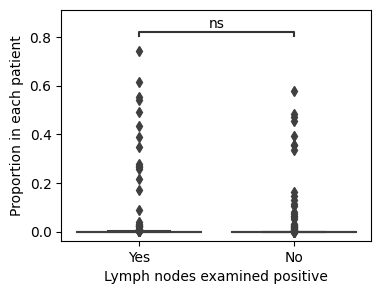

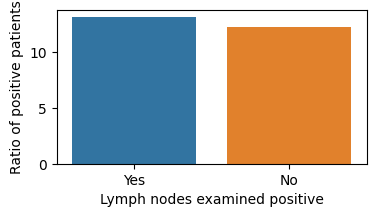

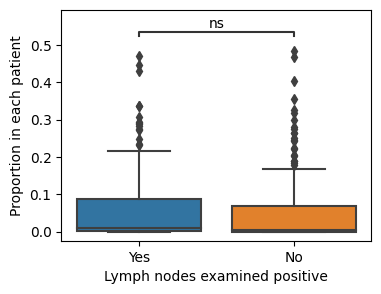

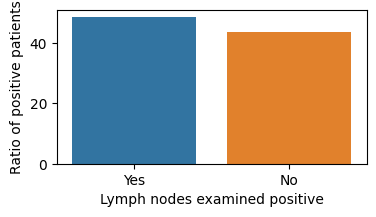

In [41]:
Histograms = bigraph_.fitted_soft_wl_subtree.Histograms
Proportions = Histograms/np.sum(Histograms, axis=1, keepdims=True)
patient_ids_discovery = list(SC_d["patientID"].unique())

from itertools import combinations
feature_name = 'Lymph nodes examined positive'
feature_list = ['Yes', 'No']
compare_list = [('Yes', 'No')]

for i in range(len(patient_subgroups_discovery)):
    subgroup_id = patient_subgroups_discovery[i]["subgroup_id"]
    characteristic_patterns = patient_subgroups_discovery[i]["characteristic_patterns"]
    if subgroup_id not in ['S1', 'S7']:
        continue
    proportion = np.sum(Proportions[:, np.array(characteristic_patterns)], axis = 1)
    DF_presentation = pd.DataFrame(
        {
            "Proportion": proportion,
            feature_name:['Yes' if survival_d.loc[survival_d["patientID"] == patient_id, feature_name].values[0]>0 else 'No'
                        for patient_id in patient_ids_discovery]

        }
    )
    DF_presentation = DF_presentation.dropna()
    f, ax = plt.subplots(figsize=(4,3))
    sns.boxplot(
        x=feature_name,
        y="Proportion",
        data=DF_presentation,
        showfliers=True,
        order = feature_list,
        # order=["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC"],
    )
    from statannotations.Annotator import Annotator

    annot = Annotator(
        ax,
        compare_list,
        data=DF_presentation,
        x=feature_name,
        y="Proportion",
        order = feature_list,
    )
    annot.configure(test="Mann-Whitney", text_format="star", loc="inside", verbose=2, )
    annot.apply_test()
    ax, test_results = annot.annotate()
    
    #ax.set(title = 'Proportion of pattern {} in each grade'.format(pattern_id[0]+1))
    ax.set(ylabel = 'Proportion in each patient')

    DF_existence = pd.DataFrame(
        {
            feature_name: feature_list,
        }
    )
    for feature in feature_list:
        data = DF_presentation.loc[
            DF_presentation[feature_name] == feature, "Proportion"
        ].values

        exisitence_ratio = np.sum(data > 0.01) / len(data)
        DF_existence.loc[
            DF_existence[feature_name] == feature, "Existence (%)"
        ] = (exisitence_ratio * 100)

    f, ax = plt.subplots(figsize=(4,2))
    sns.barplot(
        x=feature_name,
        y="Existence (%)",
        data=DF_existence,
        order=feature_list,
    )
    ax.set(ylabel = 'Ratio of positive patients')

### Fig.A.6 Alignment of cell phenotypes

In [53]:
Label_Query = SC_ev['celltypeID_original'].values
Label_Query_alignment = SC_ev['celltypeID'].values
Matching_heatmap = np.zeros((len(np.unique(Label_Query)), len(np.unique(Label_Query_alignment))))
for i in range(len(Cell_types_displayed_Jackson)):
    for j in range(len(Cell_types_displayed_Danenberg)):
        id_i = get_node_id("Jackson", "CellType")[Cell_types_displayed_Jackson[i]]
        id_j = j
        a = list(np.where(Label_Query == id_i)[0])
        b = list(np.where(Label_Query_alignment == id_j)[0])
        IoU = len(set(a).intersection(set(b))) / len(set(a).union(set(b)))
        Matching_heatmap[i, j] = IoU

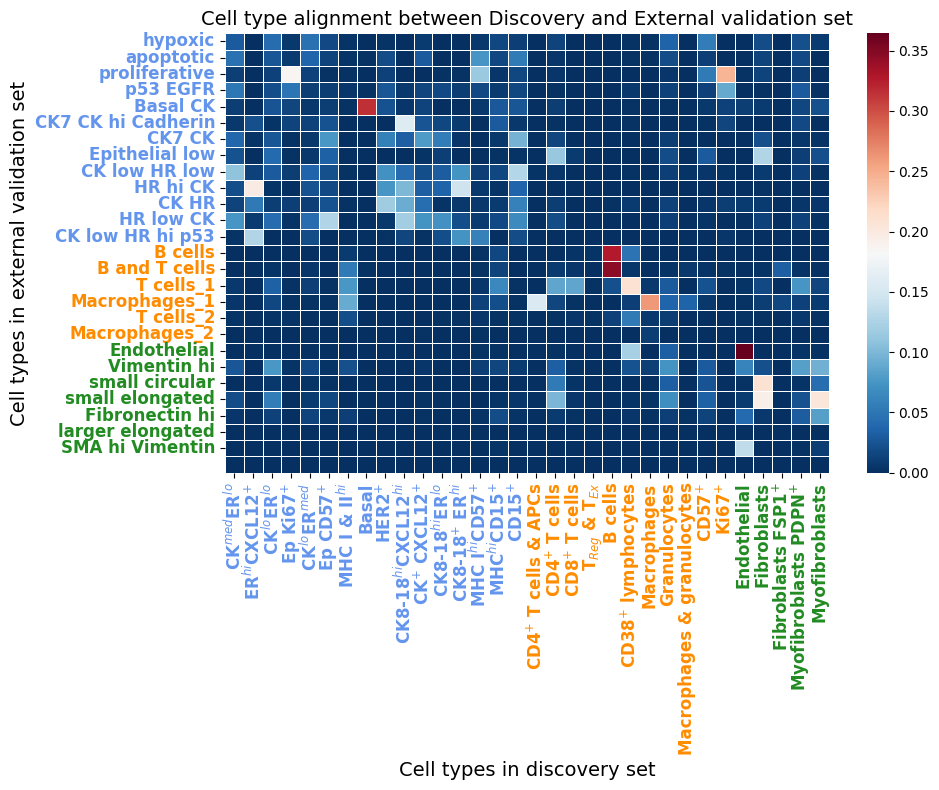

In [58]:
Cell_types_original = list(
    map(
        reverse_dict(get_node_id("Jackson", "CellType")).get,
        range(np.unique(Label_Query).shape[0]),
    )
)
Cell_types_aligned = list(
    map(
        reverse_dict(get_node_id("Danenberg", "CellType")).get,
        range(np.unique(Label_Query_alignment).shape[0]),
    )
)
f, ax = plt.subplots(figsize=(10, 8), tight_layout=True)
sns.heatmap(
    Matching_heatmap,
    ax=ax,
    xticklabels=Cell_types_displayed_Danenberg,
    yticklabels=Cell_types_displayed_Jackson,
    cmap="RdBu_r",
    vmin=0,
    # vmax=0.3,
    linewidths=0.5,
)
ax.set_ylabel("Cell types in external validation set", fontsize=14)
ax.set_xlabel("Cell types in discovery set", fontsize=14)
ax.set_title(
    "Cell type alignment between Discovery and External validation set", fontsize=14
)
ax.set_yticklabels(Cell_types_displayed_Jackson, fontsize=12, fontweight="bold")
ytickcolors = ["cornflowerblue"] * 13 + ["darkorange"] * 6 + ["forestgreen"] * 7
for ytick, color in zip(ax.get_yticklabels(), ytickcolors):
    ytick.set_color(color)
ax.set_xticklabels(Cell_types_displayed_Danenberg, fontsize=12, fontweight="bold")
xtickcolors = ["cornflowerblue"] * 16 + ["darkorange"] * 11 + ["forestgreen"] * 5 
for xtick, color in zip(ax.get_xticklabels(), xtickcolors):
    xtick.set_color(color)
    
plt.show()